## Skyler Ebelt - OL Code
#### Copying preprocessing from previous project to ensure the same architechture 

#### Same Imports as before & same seed/random state convention:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import psutil
import itertools

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, validation_curve, learning_curve 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC, SVR, LinearSVC

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score,roc_auc_score, roc_curve, average_precision_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import precision_recall_curve

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import copy
import random

#### Read Data:

In [3]:
hotel = pd.read_csv('hotel_bookings.csv')

In [4]:
accidents = pd.read_csv('US_Accidents_March23.csv')

#### Hotel Data Preprocessing:

In [5]:
hotel_clean = hotel.copy()

In [6]:
hotel_clean = hotel_clean.drop(columns = ['reservation_status', 'reservation_status_date'])

hotel_clean = hotel_clean.dropna(subset = ['is_canceled'])

In [7]:
hotel_clean = hotel_clean.apply(lambda col: col.astype('float32') if col.dtype == 'float64' else col)
#from copilot search via microsoft edge accessed on 9/8/2025, searching "current copilot search version" yields the version: 1.25054.80.0

print(hotel_clean.head())
print(hotel_clean.dtypes)

          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
0                        0                     0       2  ...   
1                        0        

In [8]:
hotel_x = hotel_clean.drop(columns = ['is_canceled'])
hotel_y = hotel_clean['is_canceled']

#Define X and Y space

In [9]:
#split data before any preprocessing to prevent leakage
hotel_x_train, hotel_x_test, hotel_y_train, hotel_y_test = train_test_split(
    hotel_x, hotel_y, test_size=0.2, stratify=hotel_y, random_state=4077010
)    


hotel_x_train_clean = hotel_x_train.copy()
hotel_x_test_clean = hotel_x_test.copy()

for col in hotel_x.select_dtypes(include=['number']).columns.tolist():
    hotel_x_train_clean[col] = hotel_x_train_clean[col].fillna(hotel_x_train_clean[col].median()) #replace numeric data with nans with median
    hotel_x_test_clean[col] = hotel_x_test_clean[col].fillna(hotel_x_train_clean[col].median())
        
for col in hotel_x.select_dtypes(include=['object']).columns.tolist():
    hotel_x_train_clean[col] = hotel_x_train_clean[col].fillna('Unknown') #replace categorical data with "Unknown"
    hotel_x_test_clean[col] = hotel_x_test_clean[col].fillna('Unknown')

low_cardinality_cols = [] #Used claude sonnet 4 on 9/11/2025 to fix encoding for high cardinality
high_cardinality_cols = []
cardinality_threshold = 20 

for col in hotel_x_train_clean.select_dtypes(include=['object']).columns:
    unique_count = hotel_x_train_clean[col].nunique()
    if unique_count <= cardinality_threshold:
        low_cardinality_cols.append(col)
    else:
        high_cardinality_cols.append(col)


numerical_cols = hotel_x_train_clean.select_dtypes(include=['number']).columns.tolist()


hotel_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat_low', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), low_cardinality_cols),
        ('cat_high', TargetEncoder(target_type='binary', smooth='auto'), high_cardinality_cols) 
    ]
)


hotel_x_train_pro = hotel_preprocessor.fit_transform(hotel_x_train_clean, hotel_y_train)  
hotel_x_train_pro = pd.DataFrame(hotel_x_train_pro)
hotel_x_test_pro = hotel_preprocessor.transform(hotel_x_test_clean)
hotel_x_test_pro = pd.DataFrame(hotel_x_test_pro)

print("Training Set: ")
print(hotel_x_train_pro.head())
print("Test Set:")
print(hotel_x_test_pro.head())

Training Set: 
         0         1         2         3         4         5         6   \
0  0.320263 -0.221062  0.500919  0.133965  0.073963  0.785127  0.250594   
1  1.031986  1.191626  0.354087 -0.436392  1.073878 -0.262236  0.250594   
2  0.554382  1.191626  0.133840  0.248037 -0.925951  0.261446  0.250594   
3  0.114237  1.191626 -0.673734 -1.234892  1.073878  1.308809  0.250594   
4 -0.934619 -0.221062  0.794582 -0.436392  0.073963  0.261446  0.250594   

         7         8         9   ...   61   62   63   64   65   66   67   68  \
0 -0.261131 -0.079808 -0.181068  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
1 -0.261131 -0.079808 -0.181068  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
2 -0.261131 -0.079808 -0.181068  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
3 -0.261131 -0.079808 -0.181068  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
4 -0.261131 -0.079808 -0.181068  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   

    69        70  
0  0.0  0.184325  
1  0.0  0.56653

D:\anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [10]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("CUDA not available - reasons could be:")
    print("- PyTorch not installed with CUDA support")
    print("- GPU drivers not installed")
    print("- CUDA toolkit not installed")
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
Number of GPUs: 1
GPU name: NVIDIA GeForce RTX 2080 SUPER
GPU memory: 8.6 GB
Using device: cuda


#### Accient Data Preprocessing:

In [11]:
accidents_clean = accidents.copy()
accidents_clean = accidents_clean.dropna(subset = ['Severity'])
accidents_clean = accidents_clean.drop(columns=['End_Time', 'Weather_Timestamp'])

In [12]:
accidents_clean = accidents_clean.apply(lambda col: col.astype('float32') if col.dtype == 'float64' else col)
#from copilot search via microsoft edge accessed on 9/8/2025, searching "current copilot search version" yields the version: 1.25054.80.0

print(accidents_clean.head())
print(accidents_clean.dtypes)

    ID   Source  Severity           Start_Time  Start_Lat  Start_Lng  End_Lat  \
0  A-1  Source2         3  2016-02-08 05:46:00  39.865147 -84.058723      NaN   
1  A-2  Source2         2  2016-02-08 06:07:59  39.928059 -82.831184      NaN   
2  A-3  Source2         2  2016-02-08 06:49:27  39.063148 -84.032608      NaN   
3  A-4  Source2         3  2016-02-08 07:23:34  39.747753 -84.205582      NaN   
4  A-5  Source2         2  2016-02-08 07:39:07  39.627781 -84.188354      NaN   

   End_Lng  Distance(mi)                                        Description  \
0      NaN          0.01  Right lane blocked due to accident on I-70 Eas...   
1      NaN          0.01  Accident on Brice Rd at Tussing Rd. Expect del...   
2      NaN          0.01  Accident on OH-32 State Route 32 Westbound at ...   
3      NaN          0.01  Accident on I-75 Southbound at Exits 52 52B US...   
4      NaN          0.01  Accident on McEwen Rd at OH-725 Miamisburg Cen...   

   ... Roundabout Station   Stop Traff

In [13]:
accidents_x = accidents_clean.drop(columns = ['Severity'])
accidents_y = accidents_clean['Severity']

In [14]:
#split data before any preprocessing to prevent leakage, copy and paste from above, why duplicate labor?
accidents_x_train, accidents_x_test, accidents_y_train, accidents_y_test = train_test_split(
    accidents_x, accidents_y, test_size=0.2, stratify=accidents_y, random_state=4077010
)    

accidents_x_train_clean = accidents_x_train.copy()
accidents_x_test_clean = accidents_x_test.copy()

for col in accidents_x_train_clean.select_dtypes(include=['number']).columns.tolist():
    accidents_x_train_clean[col] = accidents_x_train_clean[col].fillna(accidents_x_train_clean[col].median()) #replace numeric data with nans with median
    accidents_x_test_clean[col] = accidents_x_test_clean[col].fillna(accidents_x_train_clean[col].median())
        
for col in accidents_x_train_clean.select_dtypes(include=['object']).columns.tolist():
    accidents_x_train_clean[col] = accidents_x_train_clean[col].fillna('Unknown') #replace categorical data with "Unknown"
    accidents_x_test_clean[col] = accidents_x_test_clean[col].fillna('Unknown')

low_cardinality_cols_acc = []#Used claude sonnet 4 on 9/11/2025 to fix encoding for high cardinality
high_cardinality_cols_acc = []
cardinality_threshold_acc = 20 

for col in accidents_x_train_clean.select_dtypes(include=['object']).columns:
    unique_count = accidents_x_train_clean[col].nunique()
    if unique_count <= cardinality_threshold_acc:
        low_cardinality_cols_acc.append(col)
    else:
        high_cardinality_cols_acc.append(col)


numerical_cols_acc = accidents_x_train_clean.select_dtypes(include=['number']).columns.tolist()

accidents_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols_acc),
        ('cat_low', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), low_cardinality_cols_acc),
        ('cat_high', TargetEncoder(target_type='multiclass', smooth='auto'), high_cardinality_cols_acc)     
    ]
)


accidents_x_train_pro = accidents_preprocessor.fit_transform(accidents_x_train_clean, accidents_y_train)
accidents_x_train_pro = pd.DataFrame(accidents_x_train_pro)
accidents_x_test_pro = accidents_preprocessor.transform(accidents_x_test_clean)
accidents_x_test_pro = pd.DataFrame(accidents_x_test_pro)

print("Training Set: ")
print(accidents_x_train_pro.head())
print("Test Set:")
print(accidents_x_test_pro.head())

Training Set: 
         0         1         2         3         4         5         6   \
0  0.861418  1.153133  1.102278  1.256358 -0.219906 -0.463017 -0.321498   
1 -2.029145  0.833392 -2.620126  0.861479  0.013981  0.227953  0.143660   
2 -0.528118  0.452997 -0.011241  0.306023 -0.314469  0.759468  0.867238   
3 -1.527613  0.760906 -1.972245  0.771829 -0.274182  1.131528  1.229027   
4  1.127795  0.387408 -0.011241  0.306023  2.511208 -2.589076 -2.388865   

         7         8         9   ...        60        61        62        63  \
0 -0.659118  0.205861  0.334275  ...  0.251932  0.077121  0.013451  0.853616   
1 -1.722683  0.636417  0.334275  ...  0.099776  0.009898  0.000358  0.685608   
2  0.891915 -0.074501  0.334275  ...  0.331651  0.016367  0.011395  0.786170   
3 -1.146585  0.005602  0.334275  ...  0.044905  0.009541  0.011547  0.785570   
4  0.404447  0.095718  0.334275  ...  0.333953  0.015608  0.011568  0.785634   

         64        65        66        67        68  

## Best Performing Hotel NN Model From SL:

#### These will only be used to compare with OL methods

In [15]:
deep_hotel_model = MLPClassifier(
    hidden_layer_sizes=(150, 100, 75, 50),
    solver='sgd',
    learning_rate_init=0.01,
    batch_size=512,
    max_iter=50,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=3,
    random_state=4077010,
    alpha=1e-4
)

deep_hotel_cv = cross_val_score(deep_hotel_model, hotel_x_train_pro, hotel_y_train, cv=3, scoring='accuracy')
deep_hotel_score = deep_hotel_cv.mean()
print('Deep CV score:', deep_hotel_score)

Deep CV score: 0.8571802406918222


## Best Performing Accident NN Model From SL:

In [16]:
deep_accidents_model = MLPClassifier(
    hidden_layer_sizes=(150, 100, 75, 50),
    solver='sgd',
    learning_rate_init=0.01,
    batch_size=512,
    max_iter=50,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=3,
    random_state=4077010,
    alpha=1e-4
)

deep_accidents_cv = cross_val_score(deep_accidents_model, accidents_x_train_pro, accidents_y_train, cv=2, scoring='accuracy')
deep_accidents_score = deep_accidents_cv.mean()
print('Accidents Deep CV score:', deep_accidents_score)

Accidents Deep CV score: 0.9171606648257107


## Hotel Pytorch Model:

In [17]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_rate=0.0):
        super(MLPModel, self).__init__()
        
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, num_classes))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

In [18]:
hotel_input_size = hotel_x_train_pro.shape[1]
hotel_hidden_sizes = (150, 100, 75, 50) # From SL project
hotel_num_classes = 2

hotel_model = MLPModel(
    input_size=hotel_input_size,
    hidden_sizes=hotel_hidden_sizes,
    num_classes=hotel_num_classes
)

print("Hotel model architecture: Input",hotel_input_size, "Hiden", hotel_hidden_sizes, "Output",hotel_num_classes)

Hotel model architecture: Input 71 Hiden (150, 100, 75, 50) Output 2


In [19]:
hotel_x_train_tensor = torch.FloatTensor(hotel_x_train_pro.values)
hotel_y_train_tensor = torch.LongTensor(hotel_y_train.values)
hotel_x_test_tensor = torch.FloatTensor(hotel_x_test_pro.values)
hotel_y_test_tensor = torch.LongTensor(hotel_y_test.values)

## Accident Pytorch Model:

In [20]:
accidents_input_size = accidents_x_train_pro.shape[1]
accidents_hidden_sizes = (150, 100, 75, 50) 
accidents_num_classes = 4

accidents_model = MLPModel(
    input_size=accidents_input_size,
    hidden_sizes=accidents_hidden_sizes,
    num_classes=accidents_num_classes
)

print("Accidents model architecture: Input ", accidents_input_size, "Hidden ", accidents_hidden_sizes, "Output ",accidents_num_classes)

Accidents model architecture: Input  70 Hidden  (150, 100, 75, 50) Output  4


In [21]:
accidents_y_train_adjusted = accidents_y_train - 1  # Convert 1,2,3,4 to 0,1,2,3
accidents_y_test_adjusted = accidents_y_test - 1

accidents_x_train_tensor = torch.FloatTensor(accidents_x_train_pro.values)
accidents_y_train_tensor = torch.LongTensor(accidents_y_train_adjusted.values)
accidents_x_test_tensor = torch.FloatTensor(accidents_x_test_pro.values)
accidents_y_test_tensor = torch.LongTensor(accidents_y_test_adjusted.values)

# RO:

## RHC Hotel

In [120]:
hotel_params = list(hotel_model.parameters())
print("\nHotel model layer parameters:")#claude sonnet 4 9/25/2025 - little param length check
for i, param in enumerate(hotel_params):
    print(f"Layer {i}: {param.numel():,} parameters, shape: {param.shape}")


Hotel model layer parameters:
Layer 0: 10,650 parameters, shape: torch.Size([150, 71])
Layer 1: 150 parameters, shape: torch.Size([150])
Layer 2: 15,000 parameters, shape: torch.Size([100, 150])
Layer 3: 100 parameters, shape: torch.Size([100])
Layer 4: 7,500 parameters, shape: torch.Size([75, 100])
Layer 5: 75 parameters, shape: torch.Size([75])
Layer 6: 3,750 parameters, shape: torch.Size([50, 75])
Layer 7: 50 parameters, shape: torch.Size([50])
Layer 8: 100 parameters, shape: torch.Size([2, 50])
Layer 9: 2 parameters, shape: torch.Size([2])


In [121]:
hotel_x_train_ro, hotel_x_val_ro, hotel_y_train_ro, hotel_y_val_ro = train_test_split(
    hotel_x_train_tensor.cpu().numpy(), 
    hotel_y_train_tensor.cpu().numpy(), 
    test_size=0.1, 
    stratify=hotel_y_train_tensor.cpu().numpy(), 
    random_state=4077010
)

In [122]:
num_layers_to_optimize = 3

In [123]:
rhc_max_evals = 500
rhc_restart_every = 100
rhc_step_decay = 0.95   
rhc_initial_scale = 0.01
rhc_distribution = 'normal'

hotel_model_rhc = copy.deepcopy(hotel_model)

all_layers = list(hotel_model_rhc.named_parameters())
total_layers = len([name for name, _ in all_layers if 'weight' in name])

for param in hotel_model_rhc.parameters():
    param.requires_grad = False

layers_to_optimize = []
layer_count = 0

for name, param in reversed(list(hotel_model_rhc.named_parameters())):
    if 'weight' in name:
        layer_count += 1
    

    if layer_count <= num_layers_to_optimize:
        layers_to_optimize.append(name)
        param.requires_grad = True 

layers_to_optimize.reverse()

params_to_optimize = [p for p in hotel_model_rhc.parameters() if p.requires_grad]

trainable_params = sum(p.numel() for p in hotel_model_rhc.parameters() if p.requires_grad)
frozen_params = sum(p.numel() for p in hotel_model_rhc.parameters() if not p.requires_grad)
total_params = trainable_params + frozen_params


In [124]:
hotel_x_train_ro = torch.tensor(hotel_x_train_ro)
hotel_x_val_ro = torch.tensor(hotel_x_val_ro)
hotel_y_train_ro = torch.tensor(hotel_y_train_ro)
hotel_y_val_ro = torch.tensor(hotel_y_val_ro)

if torch.cuda.is_available():
    hotel_x_train_ro = hotel_x_train_ro.cuda()
    hotel_x_val_ro = hotel_x_val_ro.cuda()
    hotel_y_train_ro = hotel_y_train_ro.cuda()
    hotel_y_val_ro = hotel_y_val_ro.cuda()
device = next(hotel_model_rhc.parameters()).device
hotel_x_val_ro = hotel_x_val_ro.to(device)
hotel_y_val_ro = hotel_y_val_ro.to(device)   

In [125]:
loss_func = nn.CrossEntropyLoss()

hotel_model_rhc.eval()
with torch.no_grad():
    baseline_outputs = hotel_model_rhc(hotel_x_val_ro)
    baseline_validation_loss = loss_func(baseline_outputs, hotel_y_val_ro).item()

best_loss = baseline_validation_loss
function_evaluations = 1
perturbation_magnitude = rhc_initial_scale
rhc_losses = [baseline_validation_loss]

best_weights = [weight.data.clone() for weight in params_to_optimize]
print("Baseline validation loss: ",baseline_validation_loss)

while function_evaluations < rhc_max_evals:
    restart_triggered = (function_evaluations % rhc_restart_every == 0 and function_evaluations > 0)
    if restart_triggered:
        perturbation_magnitude *= rhc_step_decay
        print("Restart triggered at eval ",function_evaluations, "reducing step size to ",perturbation_magnitude)
        for weight, best_weight in zip(params_to_optimize, best_weights):
            weight.data = best_weight.clone()

    current_weights = [weight.data.clone() for weight in params_to_optimize]

    for weight in params_to_optimize:
        if rhc_distribution == 'normal':
            perturbation = torch.randn_like(weight) * perturbation_magnitude
        else:
            perturbation = (torch.rand_like(weight) * 2 - 1) * perturbation_magnitude
        weight.data.add_(perturbation)

    hotel_model_rhc.eval()
    with torch.no_grad():
        perturbed_outputs = hotel_model_rhc(hotel_x_val_ro)
        candidate_loss = loss_func(perturbed_outputs, hotel_y_val_ro).item()
    
    function_evaluations += 1
    rhc_losses.append(candidate_loss)
    
    # Hill climbing acceptance criterion
    improvement_found = candidate_loss < best_loss
    if improvement_found:
        best_loss = candidate_loss
        best_weights = [weight.data.clone() for weight in params_to_optimize]
    else:
        for weight, previous_weight in zip(params_to_optimize, current_weights):
            weight.data = previous_weight.clone()

for weight, best_weight in zip(params_to_optimize, best_weights):
    weight.data = best_weight.clone()

print("Best loss: ",best_loss)

Baseline validation loss:  0.6941076517105103
Restart triggered at eval  100 reducing step size to  0.0095
Restart triggered at eval  200 reducing step size to  0.009025
Restart triggered at eval  300 reducing step size to  0.00857375
Restart triggered at eval  400 reducing step size to  0.0081450625
Best loss:  0.5842950344085693


### SA Hotel

In [126]:
sa_max_evals = 500
sa_initial_temp = 1.0
sa_temp_decay = 0.99
sa_min_temp = 0.001
sa_initial_scale = 0.01
sa_scale_decay = 0.99 
sa_distribution = 'normal'

In [127]:
hotel_model_sa = copy.deepcopy(hotel_model)
hotel_model_sa = hotel_model_sa.to(device)

params_sa = list(hotel_model_sa.parameters())
params_to_freeze_sa = params_sa[:-2*num_layers_to_optimize]
params_to_optimize_sa = params_sa[-2*num_layers_to_optimize:]

for param in params_to_freeze_sa:
    param.requires_grad = False
    
for param in params_to_optimize_sa:
    param.requires_grad = True
    
criterion = nn.CrossEntropyLoss()

In [128]:
hotel_model_sa.eval()
with torch.no_grad():
    baseline_predictions = hotel_model_sa(hotel_x_val_ro)
    starting_loss = criterion(baseline_predictions, hotel_y_val_ro).item()

best_loss_sa = starting_loss
iterations_completed = 1
thermal_energy = sa_initial_temp
noise_amplitude = sa_initial_scale
sa_trajectory = [starting_loss]

optimal_weights = [weight.data.clone() for weight in params_to_optimize_sa]
print("Starting validation loss: ",starting_loss)

while iterations_completed < sa_max_evals:
    pre_move_weights = [weight.data.clone() for weight in params_to_optimize_sa]
    
    for weight in params_to_optimize_sa:
        if sa_distribution == 'normal':
            random_shift = torch.randn_like(weight) * noise_amplitude
        else:
            random_shift = (torch.rand_like(weight) * 2 - 1) * noise_amplitude
        weight.data.add_(random_shift)
    
    hotel_model_sa.eval()
    with torch.no_grad():
        trial_predictions = hotel_model_sa(hotel_x_val_ro)
        trial_loss = criterion(trial_predictions, hotel_y_val_ro).item()
    
    iterations_completed += 1
    sa_trajectory.append(trial_loss)
    
    loss_difference = trial_loss - starting_loss
    thermal_acceptance = (loss_difference < 0) or (random.random() < np.exp(-loss_difference / thermal_energy))
    
    if thermal_acceptance:
        starting_loss = trial_loss
        if trial_loss < best_loss_sa:
            best_loss_sa = trial_loss
            optimal_weights = [weight.data.clone() for weight in params_to_optimize_sa]
            print(f"Iteration {iterations_completed}: Global optimum updated: {best_loss_sa:.4f}, thermal_energy: {thermal_energy:.4f}")
    else:
        for weight, previous_weight in zip(params_to_optimize_sa, pre_move_weights):
            weight.data = previous_weight.clone()

    thermal_energy *= sa_temp_decay
    noise_amplitude *= sa_scale_decay

for weight, optimal_weight in zip(params_to_optimize_sa, optimal_weights):
    weight.data = optimal_weight.clone()

print("Best loss: ",best_loss_sa)

Starting validation loss:  0.6941076517105103
Iteration 3: Global optimum updated: 0.6939, thermal_energy: 0.9900
Iteration 15: Global optimum updated: 0.6919, thermal_energy: 0.8775
Iteration 16: Global optimum updated: 0.6909, thermal_energy: 0.8687
Iteration 17: Global optimum updated: 0.6907, thermal_energy: 0.8601
Iteration 18: Global optimum updated: 0.6902, thermal_energy: 0.8515
Iteration 19: Global optimum updated: 0.6883, thermal_energy: 0.8429
Iteration 25: Global optimum updated: 0.6868, thermal_energy: 0.7936
Iteration 27: Global optimum updated: 0.6858, thermal_energy: 0.7778
Iteration 29: Global optimum updated: 0.6840, thermal_energy: 0.7623
Iteration 32: Global optimum updated: 0.6823, thermal_energy: 0.7397
Iteration 34: Global optimum updated: 0.6814, thermal_energy: 0.7250
Iteration 36: Global optimum updated: 0.6804, thermal_energy: 0.7106
Iteration 37: Global optimum updated: 0.6802, thermal_energy: 0.7034
Iteration 40: Global optimum updated: 0.6796, thermal_ener

### GA Hotel

In [129]:
ga_max_evals = 500
ga_population_size = 20       
ga_mutation_rate = 0.1        
ga_crossover_rate = 0.8       
ga_selection_method = 'tournament' 
ga_tournament_size = 3        
ga_elitism = True              
ga_initial_scale = 0.01        
ga_distribution = 'normal' 

In [130]:
hotel_x_train_ro, hotel_x_val_ro, hotel_y_train_ro, hotel_y_val_ro = train_test_split(
    hotel_x_train_tensor.cpu().numpy(), 
    hotel_y_train_tensor.cpu().numpy(), 
    test_size=0.1, 
    stratify=hotel_y_train_tensor.cpu().numpy(), 
    random_state=4077010
)

In [131]:
hotel_model_ga = copy.deepcopy(hotel_model)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hotel_model_ga = hotel_model_ga.to(device)

params_ga = list(hotel_model_ga.parameters())
params_to_freeze_ga = params_ga[:-2*num_layers_to_optimize]
params_to_optimize_ga = params_ga[-2*num_layers_to_optimize:]

for param in params_to_freeze_ga:
    param.requires_grad = False
 
for param in params_to_optimize_ga:
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()

In [132]:
# Convert back to tensors using proper methods
hotel_x_train_ro = torch.from_numpy(hotel_x_train_ro).float()
hotel_x_val_ro = torch.from_numpy(hotel_x_val_ro).float()
hotel_y_train_ro = torch.from_numpy(hotel_y_train_ro).long()
hotel_y_val_ro = torch.from_numpy(hotel_y_val_ro).long()

# Move to CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hotel_x_train_ro = hotel_x_train_ro.to(device)
hotel_x_val_ro = hotel_x_val_ro.to(device)
hotel_y_train_ro = hotel_y_train_ro.to(device)
hotel_y_val_ro = hotel_y_val_ro.to(device)

In [133]:
original_params_ga = [param.data.clone() for param in params_to_optimize_ga]
population = []
fitness_scores = []
eval_count_ga = 0
ga_losses = []
best_loss_ga = float('inf')
best_individual = None

for i in range(ga_population_size):
    individual = [param.clone() for param in original_params_ga]
    for param in individual:
        if ga_distribution == 'normal':
            param += torch.randn_like(param) * ga_initial_scale
        else:
            param += (torch.rand_like(param) * 2 - 1) * ga_initial_scale
    
    population.append(individual)
    
    for param, ind_param in zip(params_to_optimize_ga, individual):
        param.data = ind_param.clone()
    
    hotel_model_ga.eval()
    with torch.no_grad():
        outputs = hotel_model_ga(hotel_x_val_ro)
        fitness = criterion(outputs, hotel_y_val_ro).item()
    
    fitness_scores.append(fitness)
    eval_count_ga += 1
    ga_losses.append(fitness)
    
    if fitness < best_loss_ga:
        best_loss_ga = fitness
        best_individual = [param.clone() for param in individual]

print(f"Initial population best loss: {best_loss_ga:.4f}")

generation = 0
while eval_count_ga < ga_max_evals:
    generation += 1
    new_population = []
    new_fitness_scores = []
    
    if ga_elitism:
        new_population.append([param.clone() for param in best_individual])
        new_fitness_scores.append(best_loss_ga)
    
    while len(new_population) < ga_population_size:
        candidates1 = random.sample(range(len(fitness_scores)), ga_tournament_size)
        parent1_idx = min(candidates1, key=lambda x: fitness_scores[x])
        candidates2 = random.sample(range(len(fitness_scores)), ga_tournament_size)
        parent2_idx = min(candidates2, key=lambda x: fitness_scores[x])
        
        parent1 = population[parent1_idx]
        parent2 = population[parent2_idx]
        
        if random.random() < ga_crossover_rate:
            child1 = []
            child2 = []
            for p1_param, p2_param in zip(parent1, parent2):
                mask = torch.rand_like(p1_param) > 0.5
                c1_param = torch.where(mask, p1_param, p2_param)
                c2_param = torch.where(mask, p2_param, p1_param)
                child1.append(c1_param)
                child2.append(c2_param)
        else:
            child1 = [param.clone() for param in parent1]
            child2 = [param.clone() for param in parent2]
        
        for child in [child1, child2]:
            if random.random() < ga_mutation_rate:
                for param in child:
                    if ga_distribution == 'normal':
                        param += torch.randn_like(param) * ga_initial_scale
                    else:
                        param += (torch.rand_like(param) * 2 - 1) * ga_initial_scale
            
            if len(new_population) < ga_population_size and eval_count_ga < ga_max_evals:
                for param, child_param in zip(params_to_optimize_ga, child):
                    param.data = child_param.clone()
                
                hotel_model_ga.eval()
                with torch.no_grad():
                    outputs = hotel_model_ga(hotel_x_val_ro)
                    fitness = criterion(outputs, hotel_y_val_ro).item()
                
                eval_count_ga += 1
                ga_losses.append(fitness)
                
                new_population.append(child)
                new_fitness_scores.append(fitness)
                
                if fitness < best_loss_ga:
                    best_loss_ga = fitness
                    best_individual = [param.clone() for param in child]
                    print(f"Gen {generation}, Eval {eval_count_ga}: New best loss: {best_loss_ga:.4f}")
    
    population = new_population
    fitness_scores = new_fitness_scores

for param, best_param in zip(params_to_optimize_ga, best_individual):
    param.data = best_param.clone()

print("Best loss: ",best_loss_ga)

Initial population best loss: 0.6902
Gen 2, Eval 44: New best loss: 0.6884
Gen 3, Eval 60: New best loss: 0.6862
Gen 4, Eval 88: New best loss: 0.6844
Gen 6, Eval 123: New best loss: 0.6838
Gen 7, Eval 137: New best loss: 0.6818
Gen 8, Eval 156: New best loss: 0.6817
Gen 9, Eval 173: New best loss: 0.6817
Gen 10, Eval 196: New best loss: 0.6815
Gen 10, Eval 202: New best loss: 0.6815
Gen 10, Eval 208: New best loss: 0.6813
Gen 10, Eval 210: New best loss: 0.6803
Gen 12, Eval 234: New best loss: 0.6799
Gen 12, Eval 245: New best loss: 0.6798
Gen 14, Eval 268: New best loss: 0.6791
Gen 14, Eval 274: New best loss: 0.6783
Gen 15, Eval 298: New best loss: 0.6780
Gen 17, Eval 335: New best loss: 0.6776
Gen 17, Eval 338: New best loss: 0.6776
Gen 17, Eval 342: New best loss: 0.6765
Gen 19, Eval 364: New best loss: 0.6752
Gen 21, Eval 402: New best loss: 0.6745
Gen 21, Eval 403: New best loss: 0.6732
Gen 22, Eval 425: New best loss: 0.6730
Gen 22, Eval 436: New best loss: 0.6727
Gen 23, Eval 

KeyboardInterrupt: 

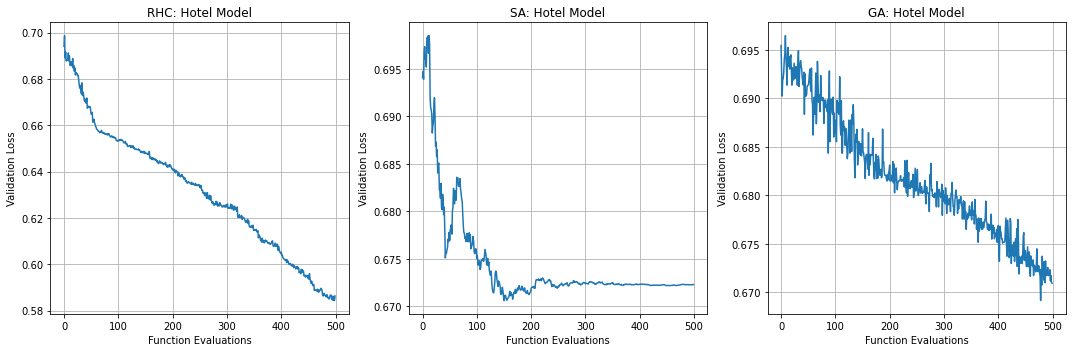

In [134]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(rhc_losses)
plt.title('RHC: Hotel Model')
plt.xlabel('Function Evaluations')
plt.ylabel('Validation Loss')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(sa_trajectory)
plt.title('SA: Hotel Model') 
plt.xlabel('Function Evaluations')
plt.ylabel('Validation Loss')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(ga_losses)
plt.title('GA: Hotel Model')
plt.xlabel('Function Evaluations')
plt.ylabel('Validation Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

In [137]:
print("\nRHC Settings:")
print(f"  Max Evaluations: {rhc_max_evals}")
print(f"  Restart Every: {rhc_restart_every}")
print(f"  Step Decay: {rhc_step_decay}")
print(f"  Initial Scale: {rhc_initial_scale}")
print(f"  Distribution: {rhc_distribution}")

print("\nSA Settings:")
print(f"  Max Evaluations: {sa_max_evals}")
print(f"  Initial Temperature: {sa_initial_temp}")
print(f"  Temperature Decay: {sa_temp_decay}")
print(f"  Min Temperature: {sa_min_temp}")
print(f"  Initial Scale: {sa_initial_scale}")
print(f"  Scale Decay: {sa_scale_decay}")
print(f"  Distribution: {sa_distribution}")

print("\nGA Settings:")
print(f"  Population Size: {ga_population_size}")
print(f"  Mutation Rate: {ga_mutation_rate}")
print(f"  Crossover Type: uniform")
print(f"  Selection Method: fitness-based")
print(f"  Elitism: Yes (keep best)")
print(f"  Distribution: {ga_distribution}")

print("\nArchitecture:")
print(f"  Layers Optimized: Last {num_layers_to_optimize} layers")
print(f"  Hotel Trainable Params: {trainable_params:,}")


RHC Settings:
  Max Evaluations: 500
  Restart Every: 100
  Step Decay: 0.95
  Initial Scale: 0.01
  Distribution: normal

SA Settings:
  Max Evaluations: 500
  Initial Temperature: 1.0
  Temperature Decay: 0.99
  Min Temperature: 0.001
  Initial Scale: 0.01
  Scale Decay: 0.99
  Distribution: normal

GA Settings:
  Population Size: 20
  Mutation Rate: 0.1
  Crossover Type: uniform
  Selection Method: fitness-based
  Elitism: Yes (keep best)
  Distribution: normal

Architecture:
  Layers Optimized: Last 3 layers
  Hotel Trainable Params: 11,577


## RHC Accidents

In [138]:
accidents_params = list(accidents_model.parameters())
print("\naccidents model layer parameters:")
for i, param in enumerate(accidents_params):
    print(f"Layer {i}: {param.numel():,} parameters, shape: {param.shape}")#claude sonnet 4 9/25/2025 - little param length check


accidents model layer parameters:
Layer 0: 10,500 parameters, shape: torch.Size([150, 70])
Layer 1: 150 parameters, shape: torch.Size([150])
Layer 2: 15,000 parameters, shape: torch.Size([100, 150])
Layer 3: 100 parameters, shape: torch.Size([100])
Layer 4: 7,500 parameters, shape: torch.Size([75, 100])
Layer 5: 75 parameters, shape: torch.Size([75])
Layer 6: 3,750 parameters, shape: torch.Size([50, 75])
Layer 7: 50 parameters, shape: torch.Size([50])
Layer 8: 200 parameters, shape: torch.Size([4, 50])
Layer 9: 4 parameters, shape: torch.Size([4])


In [139]:
accidents_x_train_ro, accidents_x_val_ro, accidents_y_train_ro, accidents_y_val_ro = train_test_split(
    accidents_x_train_tensor.cpu(), 
    accidents_y_train_tensor.cpu(), 
    test_size=0.1, 
    stratify=accidents_y_train_tensor.cpu(), 
    random_state=4077010
)

accidents_x_train_ro = torch.tensor(accidents_x_train_ro, dtype=torch.float32).to(device)
accidents_x_val_ro = torch.tensor(accidents_x_val_ro, dtype=torch.float32).to(device)
accidents_y_train_ro = torch.tensor(accidents_y_train_ro, dtype=torch.long).to(device)
accidents_y_val_ro = torch.tensor(accidents_y_val_ro, dtype=torch.long).to(device)

C:\Users\saebe\AppData\Local\Temp\ipykernel_69480\1821697774.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  accidents_x_train_ro = torch.tensor(accidents_x_train_ro, dtype=torch.float32).to(device)
C:\Users\saebe\AppData\Local\Temp\ipykernel_69480\1821697774.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  accidents_x_val_ro = torch.tensor(accidents_x_val_ro, dtype=torch.float32).to(device)
C:\Users\saebe\AppData\Local\Temp\ipykernel_69480\1821697774.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  accidents_y_train_ro = torc

In [140]:
rhc_max_evals = 500
rhc_restart_every = 100
rhc_step_decay = 0.95   
rhc_initial_scale = 0.01
rhc_distribution = 'normal'

accidents_model_rhc = copy.deepcopy(accidents_model)
all_layers = list(accidents_model_rhc.named_parameters())
total_layers = len([name for name, _ in all_layers if 'weight' in name])

for param in accidents_model_rhc.parameters():
    param.requires_grad = False

layers_to_optimize = []
layer_count = 0

for name, param in reversed(list(accidents_model_rhc.named_parameters())):
    if 'weight' in name:
        layer_count += 1
    
    if layer_count <= num_layers_to_optimize:
        layers_to_optimize.append(name)
        param.requires_grad = True 

layers_to_optimize.reverse()

params_to_optimize = [p for p in accidents_model_rhc.parameters() if p.requires_grad]

trainable_params = sum(p.numel() for p in accidents_model_rhc.parameters() if p.requires_grad)
frozen_params = sum(p.numel() for p in accidents_model_rhc.parameters() if not p.requires_grad)
total_params = trainable_params + frozen_params

accidents_x_val_ro = accidents_x_val_ro.to(device)
accidents_y_val_ro = accidents_y_val_ro.to(device)

In [141]:
loss_func = nn.CrossEntropyLoss()

accidents_model_rhc = copy.deepcopy(accidents_model)
accidents_model_rhc = accidents_model_rhc.to(device)

accidents_model_rhc.eval()
with torch.no_grad():
    baseline_outputs = accidents_model_rhc(accidents_x_val_ro)
    baseline_validation_loss = loss_func(baseline_outputs, accidents_y_val_ro).item()

best_loss = baseline_validation_loss
function_evaluations = 1
perturbation_magnitude = rhc_initial_scale
rhc_losses = [baseline_validation_loss]

best_weights = [weight.data.clone() for weight in params_to_optimize]
print("Baseline validation loss: ",baseline_validation_loss)

while function_evaluations < rhc_max_evals:
    restart_triggered = (function_evaluations % rhc_restart_every == 0 and function_evaluations > 0)
    if restart_triggered:
        perturbation_magnitude *= rhc_step_decay
        print("Restart triggered at eval ",function_evaluations, "reducing step size to ",perturbation_magnitude)
        for weight, best_weight in zip(params_to_optimize, best_weights):
            weight.data = best_weight.clone()

    current_weights = [weight.data.clone() for weight in params_to_optimize]

    for weight in params_to_optimize:
        if rhc_distribution == 'normal':
            perturbation = torch.randn_like(weight) * perturbation_magnitude
        else:
            perturbation = (torch.rand_like(weight) * 2 - 1) * perturbation_magnitude
        weight.data.add_(perturbation)

    accidents_model_rhc.eval()
    with torch.no_grad():
        perturbed_outputs = accidents_model_rhc(accidents_x_val_ro)
        candidate_loss = loss_func(perturbed_outputs, accidents_y_val_ro).item()
    
    function_evaluations += 1
    rhc_losses.append(candidate_loss)
    
    improvement_found = candidate_loss < best_loss
    if improvement_found:
        best_loss = candidate_loss
        best_weights = [weight.data.clone() for weight in params_to_optimize]
    else:
        for weight, previous_weight in zip(params_to_optimize, current_weights):
            weight.data = previous_weight.clone()

for weight, best_weight in zip(params_to_optimize, best_weights):
    weight.data = best_weight.clone()

print("Best loss: ",best_loss)

Baseline validation loss:  1.338655948638916
Restart triggered at eval  100 reducing step size to  0.0095
Restart triggered at eval  200 reducing step size to  0.009025
Restart triggered at eval  300 reducing step size to  0.00857375
Restart triggered at eval  400 reducing step size to  0.0081450625
Best loss:  1.338655948638916


### SA Accidents

In [142]:
sa_max_evals = 500
sa_initial_temp = 1.0
sa_temp_decay = 0.99
sa_min_temp = 0.001
sa_initial_scale = 0.01
sa_scale_decay = 0.99 
sa_distribution = 'normal'

In [143]:
accidents_model_sa = copy.deepcopy(accidents_model)

params_sa = list(accidents_model_sa.parameters())
params_to_freeze_sa = params_sa[:-2*num_layers_to_optimize]
params_to_optimize_sa = params_sa[-2*num_layers_to_optimize:]

for param in params_to_freeze_sa:
    param.requires_grad = False
    
for param in params_to_optimize_sa:
    param.requires_grad = True
    
accidents_model_sa = accidents_model_sa.to(device)

In [144]:
accidents_model_sa.eval()
with torch.no_grad():
    baseline_predictions = accidents_model_sa(accidents_x_val_ro)
    starting_loss = criterion(baseline_predictions, accidents_y_val_ro).item()

best_loss_sa = starting_loss
iterations_completed = 1
thermal_energy = sa_initial_temp
noise_amplitude = sa_initial_scale
sa_trajectory = [starting_loss]

optimal_weights = [weight.data.clone() for weight in params_to_optimize_sa]
print("Starting validation loss: ",starting_loss)

while iterations_completed < sa_max_evals:
    pre_move_weights = [weight.data.clone() for weight in params_to_optimize_sa]
    
    for weight in params_to_optimize_sa:
        if sa_distribution == 'normal':
            random_shift = torch.randn_like(weight) * noise_amplitude
        else:
            random_shift = (torch.rand_like(weight) * 2 - 1) * noise_amplitude
        weight.data.add_(random_shift)
    
    accidents_model_sa.eval()
    with torch.no_grad():
        trial_predictions = accidents_model_sa(accidents_x_val_ro)
        trial_loss = criterion(trial_predictions, accidents_y_val_ro).item()
    
    iterations_completed += 1
    sa_trajectory.append(trial_loss)
    
    loss_difference = trial_loss - starting_loss
    thermal_acceptance = (loss_difference < 0) or (random.random() < np.exp(-loss_difference / thermal_energy))
    
    if thermal_acceptance:
        starting_loss = trial_loss
        if trial_loss < best_loss_sa:
            best_loss_sa = trial_loss
            optimal_weights = [weight.data.clone() for weight in params_to_optimize_sa]
            print(f"Iteration {iterations_completed}: Global optimum updated: {best_loss_sa:.4f}, thermal_energy: {thermal_energy:.4f}")
    else:
        for weight, previous_weight in zip(params_to_optimize_sa, pre_move_weights):
            weight.data = previous_weight.clone()

    thermal_energy *= sa_temp_decay
    noise_amplitude *= sa_scale_decay

for weight, optimal_weight in zip(params_to_optimize_sa, optimal_weights):
    weight.data = optimal_weight.clone()

print("Best loss: ",best_loss_sa)

Starting validation loss:  1.338655948638916
Iteration 2: Global optimum updated: 1.3358, thermal_energy: 1.0000
Iteration 3: Global optimum updated: 1.3352, thermal_energy: 0.9900
Iteration 4: Global optimum updated: 1.3265, thermal_energy: 0.9801
Iteration 8: Global optimum updated: 1.3250, thermal_energy: 0.9415
Iteration 10: Global optimum updated: 1.3212, thermal_energy: 0.9227
Best loss:  1.321173906326294


### GA Accidents

In [145]:
ga_max_evals = 400
ga_population_size = 20       
ga_mutation_rate = 0.1        
ga_crossover_rate = 0.8       
ga_selection_method = 'tournament' 
ga_tournament_size = 3        
ga_elitism = True              
ga_initial_scale = 0.01        
ga_distribution = 'normal' 

In [146]:
accidents_model_ga = copy.deepcopy(accidents_model)

params_ga = list(accidents_model_ga.parameters())
params_to_freeze_ga = params_ga[:-2*num_layers_to_optimize]
params_to_optimize_ga = params_ga[-2*num_layers_to_optimize:]

for param in params_to_freeze_ga:
    param.requires_grad = False
    
for param in params_to_optimize_ga:
    param.requires_grad = True

accidents_model_ga = accidents_model_ga.to(device)

In [147]:
original_params_ga = [param.data.clone() for param in params_to_optimize_ga]
population = []
fitness_scores = []
eval_count_ga = 0
ga_losses = []
best_loss_ga = float('inf')
best_individual = None

for i in range(ga_population_size):
    individual = [param.clone() for param in original_params_ga]
    for param in individual:
        if ga_distribution == 'normal':
            param += torch.randn_like(param) * ga_initial_scale
        else:
            param += (torch.rand_like(param) * 2 - 1) * ga_initial_scale
    
    population.append(individual)
    
    for param, ind_param in zip(params_to_optimize_ga, individual):
        param.data = ind_param.clone()
    
    accidents_model_ga.eval()
    with torch.no_grad():
        outputs = accidents_model_ga(accidents_x_val_ro)
        fitness = criterion(outputs, accidents_y_val_ro).item()
    
    fitness_scores.append(fitness)
    eval_count_ga += 1
    ga_losses.append(fitness)
    
    if fitness < best_loss_ga:
        best_loss_ga = fitness
        best_individual = [param.clone() for param in individual]

print(f"Initial population best loss: {best_loss_ga:.4f}")

generation = 0
while eval_count_ga < ga_max_evals:
    generation += 1
    new_population = []
    new_fitness_scores = []
    
    if ga_elitism:
        new_population.append([param.clone() for param in best_individual])
        new_fitness_scores.append(best_loss_ga)
    
    while len(new_population) < ga_population_size:
        candidates1 = random.sample(range(len(fitness_scores)), ga_tournament_size)
        parent1_idx = min(candidates1, key=lambda x: fitness_scores[x])
        candidates2 = random.sample(range(len(fitness_scores)), ga_tournament_size)
        parent2_idx = min(candidates2, key=lambda x: fitness_scores[x])
        
        parent1 = population[parent1_idx]
        parent2 = population[parent2_idx]
        
        if random.random() < ga_crossover_rate:
            child1 = []
            child2 = []
            for p1_param, p2_param in zip(parent1, parent2):
                mask = torch.rand_like(p1_param) > 0.5
                c1_param = torch.where(mask, p1_param, p2_param)
                c2_param = torch.where(mask, p2_param, p1_param)
                child1.append(c1_param)
                child2.append(c2_param)
        else:
            child1 = [param.clone() for param in parent1]
            child2 = [param.clone() for param in parent2]
        
        for child in [child1, child2]:
            if random.random() < ga_mutation_rate:
                for param in child:
                    if ga_distribution == 'normal':
                        param += torch.randn_like(param) * ga_initial_scale
                    else:
                        param += (torch.rand_like(param) * 2 - 1) * ga_initial_scale
            
            if len(new_population) < ga_population_size and eval_count_ga < ga_max_evals:
                for param, child_param in zip(params_to_optimize_ga, child):
                    param.data = child_param.clone()
                
                accidents_model_ga.eval()
                with torch.no_grad():
                    outputs = accidents_model_ga(accidents_x_val_ro)
                    fitness = criterion(outputs, accidents_y_val_ro).item()
                
                eval_count_ga += 1
                ga_losses.append(fitness)
                
                new_population.append(child)
                new_fitness_scores.append(fitness)
                
                if fitness < best_loss_ga:
                    best_loss_ga = fitness
                    best_individual = [param.clone() for param in child]
                    print(f"Gen {generation}, Eval {eval_count_ga}: New best loss: {best_loss_ga:.4f}")
    
    population = new_population
    fitness_scores = new_fitness_scores

for param, best_param in zip(params_to_optimize_ga, best_individual):
    param.data = best_param.clone()

print("Best loss: ",best_loss_ga)

Initial population best loss: 1.3228
Gen 1, Eval 21: New best loss: 1.3118
Gen 2, Eval 40: New best loss: 1.3060
Gen 4, Eval 80: New best loss: 1.3054
Gen 4, Eval 82: New best loss: 1.3042
Gen 4, Eval 92: New best loss: 1.3007
Gen 5, Eval 100: New best loss: 1.3004
Gen 5, Eval 111: New best loss: 1.2991
Gen 6, Eval 125: New best loss: 1.2941
Gen 7, Eval 138: New best loss: 1.2865
Gen 7, Eval 139: New best loss: 1.2837
Gen 8, Eval 166: New best loss: 1.2833
Gen 8, Eval 171: New best loss: 1.2828
Gen 9, Eval 186: New best loss: 1.2803
Gen 10, Eval 192: New best loss: 1.2785
Gen 10, Eval 199: New best loss: 1.2776
Gen 10, Eval 209: New best loss: 1.2764
Gen 11, Eval 213: New best loss: 1.2726
Gen 12, Eval 232: New best loss: 1.2716
Gen 12, Eval 236: New best loss: 1.2664
Gen 13, Eval 253: New best loss: 1.2610
Gen 14, Eval 272: New best loss: 1.2505
Gen 15, Eval 294: New best loss: 1.2481
Gen 16, Eval 307: New best loss: 1.2369
Gen 18, Eval 357: New best loss: 1.2360
Gen 18, Eval 359: New

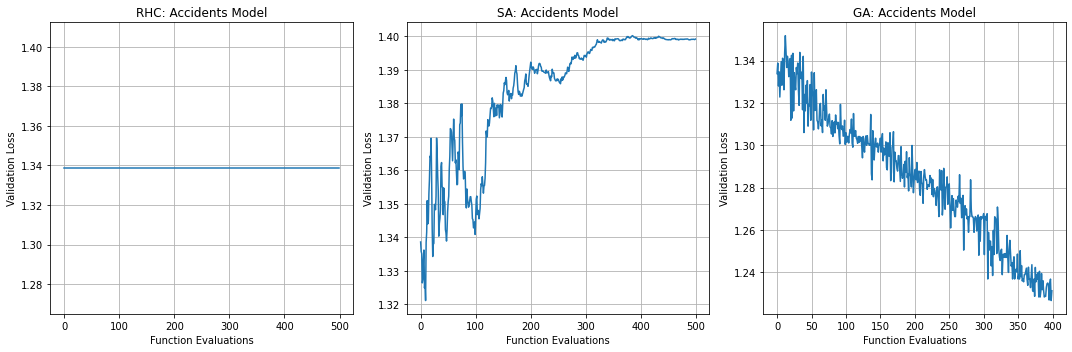

In [148]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(rhc_losses)
plt.title('RHC: Accidents Model')
plt.xlabel('Function Evaluations')
plt.ylabel('Validation Loss')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(sa_trajectory)
plt.title('SA: Accidents Model') 
plt.xlabel('Function Evaluations')
plt.ylabel('Validation Loss')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(ga_losses)
plt.title('GA: Accidents Model')
plt.xlabel('Function Evaluations')
plt.ylabel('Validation Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

In [150]:
print("\nRHC Settings:")
print(f"  Max Evaluations: {rhc_max_evals}")
print(f"  Restart Every: {rhc_restart_every}")
print(f"  Step Decay: {rhc_step_decay}")
print(f"  Initial Scale: {rhc_initial_scale}")
print(f"  Distribution: {rhc_distribution}")

print("\nSA Settings:")
print(f"  Max Evaluations: {sa_max_evals}")
print(f"  Initial Temperature: {sa_initial_temp}")
print(f"  Temperature Decay: {sa_temp_decay}")
print(f"  Min Temperature: {sa_min_temp}")
print(f"  Initial Scale: {sa_initial_scale}")
print(f"  Scale Decay: {sa_scale_decay}")
print(f"  Distribution: {sa_distribution}")

print("\nGA Settings:")
print(f"  Population Size: {ga_population_size}")
print(f"  Mutation Rate: {ga_mutation_rate}")
print(f"  Crossover Type: uniform")
print(f"  Selection Method: fitness-based")
print(f"  Elitism: Yes (keep best)")
print(f"  Distribution: {ga_distribution}")

print("\nArchitecture:")
print(f"  Layers Optimized: Last {num_layers_to_optimize} layers")
print(f"  Accidents Trainable Params: {trainable_params:,}")


RHC Settings:
  Max Evaluations: 500
  Restart Every: 100
  Step Decay: 0.95
  Initial Scale: 0.01
  Distribution: normal

SA Settings:
  Max Evaluations: 500
  Initial Temperature: 1.0
  Temperature Decay: 0.99
  Min Temperature: 0.001
  Initial Scale: 0.01
  Scale Decay: 0.99
  Distribution: normal

GA Settings:
  Population Size: 20
  Mutation Rate: 0.1
  Crossover Type: uniform
  Selection Method: fitness-based
  Elitism: Yes (keep best)
  Distribution: normal

Architecture:
  Layers Optimized: Last 3 layers
  Accidents Trainable Params: 11,679


# End RO

# Adam Ablation

### Hotel Data:

In [151]:
adam_max_epochs = 15 
adam_batch_size = 512 
validation_loss_threshold = 0.65
num_seeds = 5

In [152]:
hotel_val_dataset = TensorDataset(hotel_x_val_ro, hotel_y_val_ro)
hotel_val_loader = DataLoader(hotel_val_dataset, batch_size=adam_batch_size, shuffle=False)

optimizer_configs = {
    'SGD_no_momentum': {
        'optimizer_class': optim.SGD,
        'params': {'lr': 0.01, 'momentum': 0.0, 'weight_decay': 1e-4}
    },
    'SGD_momentum': {
        'optimizer_class': optim.SGD,
        'params': {'lr': 0.01, 'momentum': 0.9, 'weight_decay': 1e-4}
    },
    'SGD_nesterov': {
        'optimizer_class': optim.SGD,
        'params': {'lr': 0.01, 'momentum': 0.9, 'nesterov': True, 'weight_decay': 1e-4}
    },
    'Adam_baseline': {
        'optimizer_class': optim.Adam,
        'params': {'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-8, 'weight_decay': 1e-4}
    },
    'Adam_no_bias_correction': {
        'optimizer_class': optim.Adam,
        'params': {'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-8, 'weight_decay': 1e-4, 'amsgrad': False}
    },
    'Adam_beta1_zero': { 
        'optimizer_class': optim.Adam,
        'params': {'lr': 0.001, 'betas': (0.0, 0.999), 'eps': 1e-8, 'weight_decay': 1e-4}
    },
    'AdamW': {
        'optimizer_class': optim.AdamW,
        'params': {'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-8, 'weight_decay': 1e-4}
    }
}

In [153]:
hotel_x_train_tensor = hotel_x_train_tensor.to(device)
hotel_y_train_tensor = hotel_y_train_tensor.to(device)
hotel_x_val_ro = hotel_x_val_ro.to(device)
hotel_y_val_ro = hotel_y_val_ro.to(device)

hotel_train_dataset = TensorDataset(hotel_x_train_tensor, hotel_y_train_tensor)
hotel_train_loader = DataLoader(hotel_train_dataset, batch_size=adam_batch_size, shuffle=True)

hotel_val_dataset = TensorDataset(hotel_x_val_ro, hotel_y_val_ro)
hotel_val_loader = DataLoader(hotel_val_dataset, batch_size=adam_batch_size, shuffle=False)

all_results = {}
seeds_list = [40770100, 40770101, 40770102, 40770103, 40770104]

In [154]:
for optimizer_name, config in optimizer_configs.items():
    optimizer_results = []
    
    for seed_idx, seed in enumerate(seeds_list):
        print(f"\n--- Seed {seed_idx + 1}/5 (seed: {seed}) ---")
        print(f"Training with {optimizer_name} (seed: {seed})...")
        
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        model_copy = MLPModel(
            input_size=hotel_input_size,
            hidden_sizes=hotel_hidden_sizes,
            num_classes=hotel_num_classes
        )
        
        model_copy = model_copy.to(device)
        
        for param in model_copy.parameters():
            param.requires_grad = True
        
        for layer in model_copy.modules():
            if isinstance(layer, nn.Linear):
                torch.nn.init.kaiming_uniform_(layer.weight)
                torch.nn.init.zeros_(layer.bias)
        
        optimizer = config['optimizer_class'](model_copy.parameters(), **config['params'])
        criterion = nn.CrossEntropyLoss()
        
        train_losses = []
        val_losses = []
        epochs_to_threshold = None
        gradient_evaluations = 0

        for epoch in range(adam_max_epochs):
            model_copy.train()
            epoch_train_loss = 0.0
            epoch_batches = 0
            
            for batch_x, batch_y in hotel_train_loader:
                optimizer.zero_grad()
                outputs = model_copy(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
                epoch_train_loss += loss.item()
                gradient_evaluations += 1
                epoch_batches += 1
            
            avg_train_loss = epoch_train_loss / epoch_batches
            train_losses.append(avg_train_loss)
            
            model_copy.eval()
            epoch_val_loss = 0.0
            val_batches = 0
            
            with torch.no_grad():
                for batch_x, batch_y in hotel_val_loader:
                    outputs = model_copy(batch_x)
                    loss = criterion(outputs, batch_y)
                    epoch_val_loss += loss.item()
                    val_batches += 1
            
            avg_val_loss = epoch_val_loss / val_batches
            val_losses.append(avg_val_loss)
            
            if epochs_to_threshold is None and avg_val_loss <= validation_loss_threshold:
                epochs_to_threshold = epoch + 1
            
            if (epoch + 1) % 5 == 0:
                print(f"  Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
        
        final_train_loss = train_losses[-1]
        final_val_loss = val_losses[-1]
        generalization_gap = final_val_loss - final_train_loss
        
        if epochs_to_threshold is None:
            epochs_to_threshold = f">{adam_max_epochs}"
        
        print(f"  Final: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")
        print(f"  Epochs to threshold: {epochs_to_threshold}")
        print(f"  Gradient evaluations: {gradient_evaluations}")
        print(f"  Generalization gap: {generalization_gap:.4f}")
        
        result = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'epochs_to_threshold': epochs_to_threshold,
            'gradient_evaluations': gradient_evaluations,
            'final_train_loss': final_train_loss,
            'final_val_loss': final_val_loss,
            'generalization_gap': generalization_gap
        }
        
        optimizer_results.append(result)
    
    all_results[optimizer_name] = optimizer_results


--- Seed 1/5 (seed: 40770100) ---
Training with SGD_no_momentum (seed: 40770100)...
  Epoch 5: Train Loss = 0.4201, Val Loss = 0.4114
  Epoch 10: Train Loss = 0.3758, Val Loss = 0.3716
  Epoch 15: Train Loss = 0.3533, Val Loss = 0.3511
  Final: Train = 0.3533, Val = 0.3511
  Epochs to threshold: 1
  Gradient evaluations: 2805
  Generalization gap: -0.0022

--- Seed 2/5 (seed: 40770101) ---
Training with SGD_no_momentum (seed: 40770101)...
  Epoch 5: Train Loss = 0.4345, Val Loss = 0.4237
  Epoch 10: Train Loss = 0.3898, Val Loss = 0.3833
  Epoch 15: Train Loss = 0.3650, Val Loss = 0.3602
  Final: Train = 0.3650, Val = 0.3602
  Epochs to threshold: 1
  Gradient evaluations: 2805
  Generalization gap: -0.0048

--- Seed 3/5 (seed: 40770102) ---
Training with SGD_no_momentum (seed: 40770102)...
  Epoch 5: Train Loss = 0.4367, Val Loss = 0.4278
  Epoch 10: Train Loss = 0.3955, Val Loss = 0.3911
  Epoch 15: Train Loss = 0.3715, Val Loss = 0.3710
  Final: Train = 0.3715, Val = 0.3710
  Epoch

SGD_no_momentum      | Val Loss: 0.3602 ± 0.0069 | Gen Gap: -0.0022
SGD_momentum         | Val Loss: 0.2790 ± 0.0064 | Gen Gap: -0.0034
SGD_nesterov         | Val Loss: 0.2748 ± 0.0054 | Gen Gap: -0.0051
Adam_baseline        | Val Loss: 0.2390 ± 0.0039 | Gen Gap: -0.0070
Adam_no_bias_correction | Val Loss: 0.2390 ± 0.0039 | Gen Gap: -0.0070
Adam_beta1_zero      | Val Loss: 0.2431 ± 0.0041 | Gen Gap: -0.0128
AdamW                | Val Loss: 0.2305 ± 0.0014 | Gen Gap: -0.0093

Best optimizer (lowest median val loss): AdamW


C:\Users\saebe\AppData\Local\Temp\ipykernel_69480\1657648913.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(threshold_times, labels=threshold_labels)
C:\Users\saebe\AppData\Local\Temp\ipykernel_69480\1657648913.py:79: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(gap_data, labels=gap_labels)
C:\Users\saebe\AppData\Local\Temp\ipykernel_69480\1657648913.py:94: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(val_loss_data, labels=val_loss_labels)


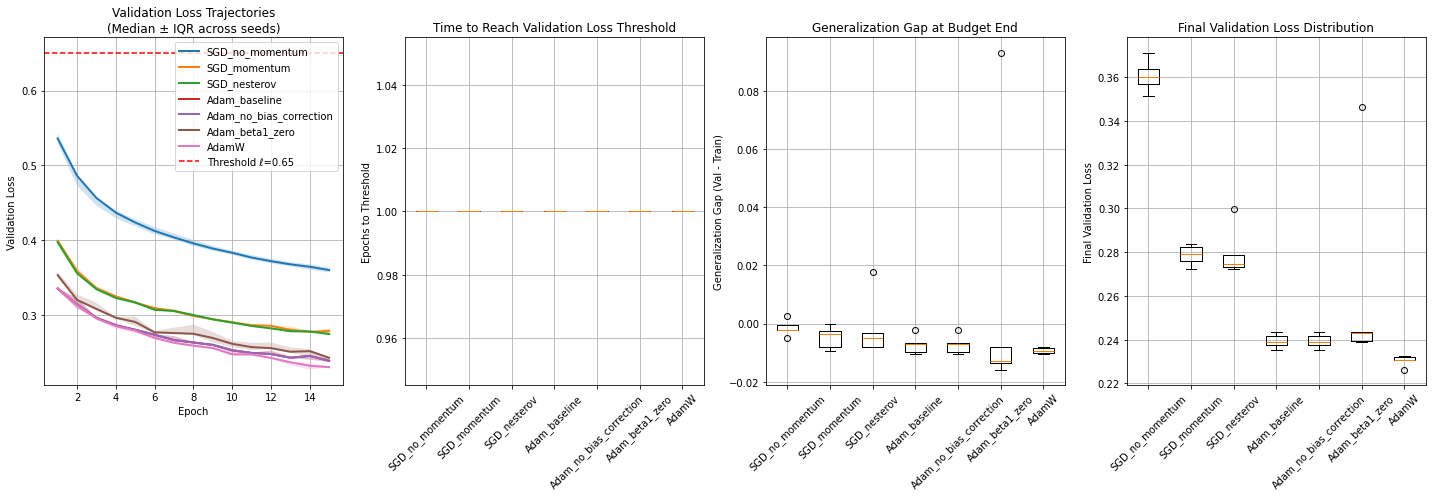

SGD_no_momentum      0.3602       -0.0022    1            2805         0.0069         
SGD_momentum         0.2790       -0.0034    1            2805         0.0064         
SGD_nesterov         0.2748       -0.0051    1            2805         0.0054         
Adam_baseline        0.2390       -0.0070    1            2805         0.0039         
Adam_no_bias_correction 0.2390       -0.0070    1            2805         0.0039         
Adam_beta1_zero      0.2431       -0.0128    1            2805         0.0041         
AdamW                0.2305       -0.0093    1            2805         0.0014         

Best performing optimizer: AdamW
Validation loss threshold ℓ = 0.65
Budget: 15 epochs, 512 batch size
Stability analysis: 5 seeds per optimizer


In [155]:
stability_summary = {}
for optimizer_name, results_list in all_results.items():
    
    final_val_losses = [r['final_val_loss'] for r in results_list]
    gen_gaps = [r['generalization_gap'] for r in results_list]
    grad_evals = [r['gradient_evaluations'] for r in results_list]

    val_median = np.median(final_val_losses)
    val_q1 = np.percentile(final_val_losses, 25)
    val_q3 = np.percentile(final_val_losses, 75)
    val_iqr = val_q3 - val_q1
    
    gap_median = np.median(gen_gaps)
    
    stability_summary[optimizer_name] = {
        'val_median': val_median,
        'val_iqr': val_iqr,
        'gap_median': gap_median,
        'grad_evals_median': np.median(grad_evals)
    }
    
    print(f"{optimizer_name:20} | Val Loss: {val_median:.4f} ± {val_iqr:.4f} | Gen Gap: {gap_median:.4f}")

best_optimizer = min(stability_summary.keys(), key=lambda x: stability_summary[x]['val_median'])
print(f"\nBest optimizer (lowest median val loss): {best_optimizer}")

plt.figure(figsize=(20, 12))

plt.subplot(2, 4, 1)
for optimizer_name, results_list in all_results.items():
    max_epochs_actual = min(len(r['val_losses']) for r in results_list)
    val_trajectories = np.array([r['val_losses'][:max_epochs_actual] for r in results_list])
    
    median_trajectory = np.median(val_trajectories, axis=0)
    q1_trajectory = np.percentile(val_trajectories, 25, axis=0)
    q3_trajectory = np.percentile(val_trajectories, 75, axis=0)
    
    epochs = range(1, max_epochs_actual + 1)
    plt.plot(epochs, median_trajectory, label=optimizer_name, linewidth=2)
    plt.fill_between(epochs, q1_trajectory, q3_trajectory, alpha=0.2)

plt.axhline(y=validation_loss_threshold, color='red', linestyle='--', label=f'Threshold ℓ={validation_loss_threshold}')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Trajectories\n(Median ± IQR across seeds)')
plt.legend()
plt.grid(True)

plt.subplot(2, 4, 2)
threshold_times = []
threshold_labels = []

for optimizer_name, results_list in all_results.items():
    times = []
    for result in results_list:
        if isinstance(result['epochs_to_threshold'], int):
            times.append(result['epochs_to_threshold'])
        else:
            times.append(adam_max_epochs + 1)
    
    threshold_times.append(times)
    threshold_labels.append(optimizer_name)

plt.boxplot(threshold_times, labels=threshold_labels)
plt.ylabel('Epochs to Threshold')
plt.title('Time to Reach Validation Loss Threshold')
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(2, 4, 3)
gap_data = []
gap_labels = []

for optimizer_name, results_list in all_results.items():
    gaps = [r['generalization_gap'] for r in results_list]
    gap_data.append(gaps)
    gap_labels.append(optimizer_name)

plt.boxplot(gap_data, labels=gap_labels)
plt.ylabel('Generalization Gap (Val - Train)')
plt.title('Generalization Gap at Budget End')
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(2, 4, 4)
val_loss_data = []
val_loss_labels = []

for optimizer_name, results_list in all_results.items():
    val_losses = [r['final_val_loss'] for r in results_list]
    val_loss_data.append(val_losses)
    val_loss_labels.append(optimizer_name)

plt.boxplot(val_loss_data, labels=val_loss_labels)
plt.ylabel('Final Validation Loss')
plt.title('Final Validation Loss Distribution')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

for optimizer_name in optimizer_configs.keys():
    stats = stability_summary[optimizer_name]
    
    threshold_times = []
    for result in all_results[optimizer_name]:
        if isinstance(result['epochs_to_threshold'], int):
            threshold_times.append(result['epochs_to_threshold'])
    
    if threshold_times:
        median_time = np.median(threshold_times)
        time_str = f"{median_time:.0f}"
    else:
        time_str = f">{adam_max_epochs}"
    
    print(f"{optimizer_name:<20} {stats['val_median']:<12.4f} {stats['gap_median']:<10.4f} "
          f"{time_str:<12} {stats['grad_evals_median']:<12.0f} {stats['val_iqr']:<15.4f}")

print(f"\nBest performing optimizer: {best_optimizer}")
print(f"Validation loss threshold ℓ = {validation_loss_threshold}")
print(f"Budget: {adam_max_epochs} epochs, {adam_batch_size} batch size")
print(f"Stability analysis: {num_seeds} seeds per optimizer")
print(f"{'='*100}")


### Accidents Data

In [156]:
adam_max_epochs = 15 
adam_batch_size = 512 
validation_loss_threshold = 0.2
num_seeds = 5

In [157]:
accidents_val_dataset = TensorDataset(accidents_x_val_ro, accidents_y_val_ro)
accidents_val_loader = DataLoader(accidents_val_dataset, batch_size=adam_batch_size, shuffle=False)

accidents_x_train_tensor = accidents_x_train_tensor.to(device)
accidents_y_train_tensor = accidents_y_train_tensor.to(device)
accidents_x_val_ro = accidents_x_val_ro.to(device)
accidents_y_val_ro = accidents_y_val_ro.to(device)

optimizer_configs = {
    'SGD_no_momentum': {
        'optimizer_class': optim.SGD,
        'params': {'lr': 0.01, 'momentum': 0.0, 'weight_decay': 1e-4}
    },
    'SGD_momentum': {
        'optimizer_class': optim.SGD,
        'params': {'lr': 0.01, 'momentum': 0.9, 'weight_decay': 1e-4}
    },
    'SGD_nesterov': {
        'optimizer_class': optim.SGD,
        'params': {'lr': 0.01, 'momentum': 0.9, 'nesterov': True, 'weight_decay': 1e-4}
    },
    'Adam_baseline': {
        'optimizer_class': optim.Adam,
        'params': {'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-8, 'weight_decay': 1e-4}
    },
    'Adam_no_bias_correction': {
        'optimizer_class': optim.Adam,
        'params': {'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-8, 'weight_decay': 1e-4, 'amsgrad': False}
    },
    'Adam_beta1_zero': { 
        'optimizer_class': optim.Adam,
        'params': {'lr': 0.001, 'betas': (0.0, 0.999), 'eps': 1e-8, 'weight_decay': 1e-4}
    },
    'AdamW': {
        'optimizer_class': optim.AdamW,
        'params': {'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-8, 'weight_decay': 1e-4}
    }
}

In [158]:
all_results = {}

accidents_train_dataset = TensorDataset(accidents_x_train_tensor, accidents_y_train_tensor)
accidents_train_loader = DataLoader(accidents_train_dataset, batch_size=adam_batch_size, shuffle=True)

accidents_val_dataset = TensorDataset(accidents_x_val_ro, accidents_y_val_ro)
accidents_val_loader = DataLoader(accidents_val_dataset, batch_size=adam_batch_size, shuffle=False)

In [159]:
np.random.seed(4077010)
#10/8/25 first sample, runtime > 8 hrs, halving until feasible 
#10/9/25 second sample, runtime approx > 8 hrs (again), halving 
#10/9/25 second sample, runtime approx > 1 hr, halving 
accidents_sample_size = int(len(accidents_x_train_pro) * .0625) 
sample_indices = np.random.choice(
    len(accidents_x_train_pro), 
    size=accidents_sample_size, 
    replace=False
)

accidents_x_train_sample = accidents_x_train_pro.iloc[sample_indices]
accidents_y_train_sample = accidents_y_train_adjusted.iloc[sample_indices] 

accidents_val_sample_size = int(len(accidents_x_test_pro) * .0625)
val_sample_indices = np.random.choice(
    len(accidents_x_test_pro),
    size=accidents_val_sample_size,
    replace=False
)

accidents_x_val_sample = accidents_x_test_pro.iloc[val_sample_indices] 
accidents_y_val_sample = accidents_y_test_adjusted.iloc[val_sample_indices]
accidents_train_dataset_sample = TensorDataset(
    torch.FloatTensor(accidents_x_train_sample.values).to(device), 
    torch.LongTensor(accidents_y_train_sample.values).to(device)
)


accidents_train_loader = DataLoader(
    accidents_train_dataset_sample, 
    batch_size=adam_batch_size,
    shuffle=True
)

accidents_val_dataset_sample = TensorDataset(
    torch.FloatTensor(accidents_x_val_sample.values).to(device),
    torch.LongTensor(accidents_y_val_sample.values).to(device)
)

accidents_val_loader = DataLoader(
    accidents_val_dataset_sample, 
    batch_size=adam_batch_size, 
    shuffle=False
)

In [160]:
for optimizer_name, config in optimizer_configs.items():
    optimizer_results = []
    
    for seed_idx, seed in enumerate(seeds_list):
        print(f"\n--- Seed {seed_idx + 1}/5 (seed: {seed}) ---")
        print(f"Training with {optimizer_name} (seed: {seed})...")
        
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        model_copy = MLPModel(
            input_size=accidents_input_size,
            hidden_sizes=accidents_hidden_sizes,
            num_classes=accidents_num_classes
        )
        
        model_copy = model_copy.to(device)
        
        for param in model_copy.parameters():
            param.requires_grad = True
        
        for layer in model_copy.modules():
            if isinstance(layer, nn.Linear):
                torch.nn.init.kaiming_uniform_(layer.weight)
                torch.nn.init.zeros_(layer.bias)
        
        optimizer = config['optimizer_class'](model_copy.parameters(), **config['params'])
        criterion = nn.CrossEntropyLoss()
        
        train_losses = []
        val_losses = []
        epochs_to_threshold = None
        gradient_evaluations = 0

        for epoch in range(adam_max_epochs):
            model_copy.train()
            epoch_train_loss = 0.0
            epoch_batches = 0
            
            for batch_x, batch_y in accidents_train_loader:
                optimizer.zero_grad()
                outputs = model_copy(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
                epoch_train_loss += loss.item()
                gradient_evaluations += 1
                epoch_batches += 1
            
            avg_train_loss = epoch_train_loss / epoch_batches
            train_losses.append(avg_train_loss)
            
            model_copy.eval()
            epoch_val_loss = 0.0
            val_batches = 0
            
            with torch.no_grad():
                for batch_x, batch_y in accidents_val_loader:
                    outputs = model_copy(batch_x)
                    loss = criterion(outputs, batch_y)
                    epoch_val_loss += loss.item()
                    val_batches += 1
            
            avg_val_loss = epoch_val_loss / val_batches
            val_losses.append(avg_val_loss)
            
            if epochs_to_threshold is None and avg_val_loss <= validation_loss_threshold:
                epochs_to_threshold = epoch + 1
            
            if (epoch + 1) % 5 == 0:
                print(f"  Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
        
        final_train_loss = train_losses[-1]
        final_val_loss = val_losses[-1]
        generalization_gap = final_val_loss - final_train_loss
        
        if epochs_to_threshold is None:
            epochs_to_threshold = f">{adam_max_epochs}"
        
        print(f"  Final: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")
        print(f"  Epochs to threshold: {epochs_to_threshold}")
        print(f"  Gradient evaluations: {gradient_evaluations}")
        print(f"  Generalization gap: {generalization_gap:.4f}")
        
        result = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'epochs_to_threshold': epochs_to_threshold,
            'gradient_evaluations': gradient_evaluations,
            'final_train_loss': final_train_loss,
            'final_val_loss': final_val_loss,
            'generalization_gap': generalization_gap
        }
        
        optimizer_results.append(result)
    
    all_results[optimizer_name] = optimizer_results


--- Seed 1/5 (seed: 40770100) ---
Training with SGD_no_momentum (seed: 40770100)...
  Epoch 5: Train Loss = 0.3129, Val Loss = 0.3016
  Epoch 10: Train Loss = 0.2929, Val Loss = 0.2829
  Epoch 15: Train Loss = 0.2806, Val Loss = 0.2710
  Final: Train = 0.2806, Val = 0.2710
  Epochs to threshold: >15
  Gradient evaluations: 11325
  Generalization gap: -0.0096

--- Seed 2/5 (seed: 40770101) ---
Training with SGD_no_momentum (seed: 40770101)...
  Epoch 5: Train Loss = 0.3085, Val Loss = 0.2992
  Epoch 10: Train Loss = 0.2888, Val Loss = 0.2793
  Epoch 15: Train Loss = 0.2784, Val Loss = 0.2693
  Final: Train = 0.2784, Val = 0.2693
  Epochs to threshold: >15
  Gradient evaluations: 11325
  Generalization gap: -0.0091

--- Seed 3/5 (seed: 40770102) ---
Training with SGD_no_momentum (seed: 40770102)...
  Epoch 5: Train Loss = 0.3118, Val Loss = 0.3011
  Epoch 10: Train Loss = 0.2918, Val Loss = 0.2845
  Epoch 15: Train Loss = 0.2807, Val Loss = 0.2714
  Final: Train = 0.2807, Val = 0.2714
 

SGD_no_momentum      | Val Loss: 0.2711 ± 0.0004 | Gen Gap: -0.0093
SGD_momentum         | Val Loss: 0.2394 ± 0.0013 | Gen Gap: -0.0077
SGD_nesterov         | Val Loss: 0.2384 ± 0.0003 | Gen Gap: -0.0075
Adam_baseline        | Val Loss: 0.2301 ± 0.0011 | Gen Gap: -0.0073
Adam_no_bias_correction | Val Loss: 0.2301 ± 0.0011 | Gen Gap: -0.0073
Adam_beta1_zero      | Val Loss: 0.2328 ± 0.0011 | Gen Gap: -0.0058
AdamW                | Val Loss: 0.2288 ± 0.0010 | Gen Gap: -0.0013

Best optimizer (lowest median val loss): AdamW


C:\Users\saebe\AppData\Local\Temp\ipykernel_69480\1657648913.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(threshold_times, labels=threshold_labels)
C:\Users\saebe\AppData\Local\Temp\ipykernel_69480\1657648913.py:79: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(gap_data, labels=gap_labels)
C:\Users\saebe\AppData\Local\Temp\ipykernel_69480\1657648913.py:94: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(val_loss_data, labels=val_loss_labels)


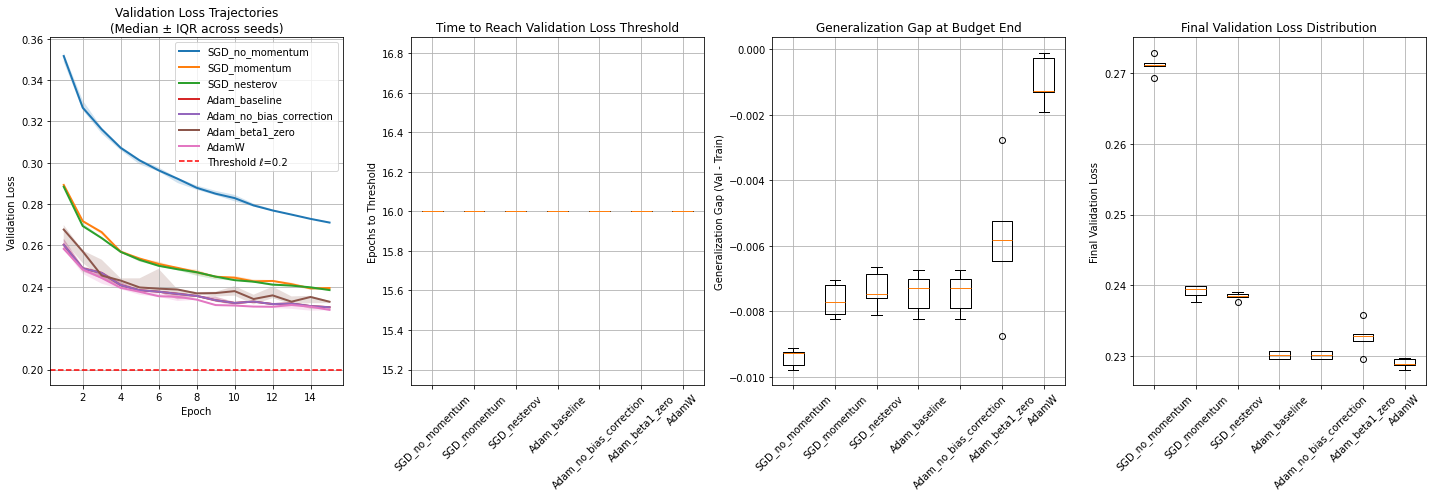

SGD_no_momentum      0.2711       -0.0093    >15          11325        0.0004         
SGD_momentum         0.2394       -0.0077    >15          11325        0.0013         
SGD_nesterov         0.2384       -0.0075    >15          11325        0.0003         
Adam_baseline        0.2301       -0.0073    >15          11325        0.0011         
Adam_no_bias_correction 0.2301       -0.0073    >15          11325        0.0011         
Adam_beta1_zero      0.2328       -0.0058    >15          11325        0.0011         
AdamW                0.2288       -0.0013    >15          11325        0.0010         

Best performing optimizer: AdamW
Validation loss threshold ℓ = 0.2
Budget: 15 epochs, 512 batch size
Stability analysis: 5 seeds per optimizer


In [161]:
stability_summary = {}
for optimizer_name, results_list in all_results.items():
    
    final_val_losses = [r['final_val_loss'] for r in results_list]
    gen_gaps = [r['generalization_gap'] for r in results_list]
    grad_evals = [r['gradient_evaluations'] for r in results_list]

    val_median = np.median(final_val_losses)
    val_q1 = np.percentile(final_val_losses, 25)
    val_q3 = np.percentile(final_val_losses, 75)
    val_iqr = val_q3 - val_q1
    
    gap_median = np.median(gen_gaps)
    
    stability_summary[optimizer_name] = {
        'val_median': val_median,
        'val_iqr': val_iqr,
        'gap_median': gap_median,
        'grad_evals_median': np.median(grad_evals)
    }
    
    print(f"{optimizer_name:20} | Val Loss: {val_median:.4f} ± {val_iqr:.4f} | Gen Gap: {gap_median:.4f}")

best_optimizer = min(stability_summary.keys(), key=lambda x: stability_summary[x]['val_median'])
print(f"\nBest optimizer (lowest median val loss): {best_optimizer}")

plt.figure(figsize=(20, 12))

plt.subplot(2, 4, 1)
for optimizer_name, results_list in all_results.items():
    max_epochs_actual = min(len(r['val_losses']) for r in results_list)
    val_trajectories = np.array([r['val_losses'][:max_epochs_actual] for r in results_list])
    
    median_trajectory = np.median(val_trajectories, axis=0)
    q1_trajectory = np.percentile(val_trajectories, 25, axis=0)
    q3_trajectory = np.percentile(val_trajectories, 75, axis=0)
    
    epochs = range(1, max_epochs_actual + 1)
    plt.plot(epochs, median_trajectory, label=optimizer_name, linewidth=2)
    plt.fill_between(epochs, q1_trajectory, q3_trajectory, alpha=0.2)

plt.axhline(y=validation_loss_threshold, color='red', linestyle='--', label=f'Threshold ℓ={validation_loss_threshold}')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Trajectories\n(Median ± IQR across seeds)')
plt.legend()
plt.grid(True)

plt.subplot(2, 4, 2)
threshold_times = []
threshold_labels = []

for optimizer_name, results_list in all_results.items():
    times = []
    for result in results_list:
        if isinstance(result['epochs_to_threshold'], int):
            times.append(result['epochs_to_threshold'])
        else:
            times.append(adam_max_epochs + 1)
    
    threshold_times.append(times)
    threshold_labels.append(optimizer_name)

plt.boxplot(threshold_times, labels=threshold_labels)
plt.ylabel('Epochs to Threshold')
plt.title('Time to Reach Validation Loss Threshold')
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(2, 4, 3)
gap_data = []
gap_labels = []

for optimizer_name, results_list in all_results.items():
    gaps = [r['generalization_gap'] for r in results_list]
    gap_data.append(gaps)
    gap_labels.append(optimizer_name)

plt.boxplot(gap_data, labels=gap_labels)
plt.ylabel('Generalization Gap (Val - Train)')
plt.title('Generalization Gap at Budget End')
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(2, 4, 4)
val_loss_data = []
val_loss_labels = []

for optimizer_name, results_list in all_results.items():
    val_losses = [r['final_val_loss'] for r in results_list]
    val_loss_data.append(val_losses)
    val_loss_labels.append(optimizer_name)

plt.boxplot(val_loss_data, labels=val_loss_labels)
plt.ylabel('Final Validation Loss')
plt.title('Final Validation Loss Distribution')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

for optimizer_name in optimizer_configs.keys():
    stats = stability_summary[optimizer_name]
    
    threshold_times = []
    for result in all_results[optimizer_name]:
        if isinstance(result['epochs_to_threshold'], int):
            threshold_times.append(result['epochs_to_threshold'])
    
    if threshold_times:
        median_time = np.median(threshold_times)
        time_str = f"{median_time:.0f}"
    else:
        time_str = f">{adam_max_epochs}"
    
    print(f"{optimizer_name:<20} {stats['val_median']:<12.4f} {stats['gap_median']:<10.4f} "
          f"{time_str:<12} {stats['grad_evals_median']:<12.0f} {stats['val_iqr']:<15.4f}")

print(f"\nBest performing optimizer: {best_optimizer}")
print(f"Validation loss threshold ℓ = {validation_loss_threshold}")
print(f"Budget: {adam_max_epochs} epochs, {adam_batch_size} batch size")
print(f"Stability analysis: {num_seeds} seeds per optimizer")
print(f"{'='*100}")


# End Adam

# Regularization

### Hotel Data: Baseline

In [162]:
reg_max_epochs = 15
reg_batch_size = 512
num_seeds = 5
seeds_list = [40770100, 40770101, 40770102, 40770103, 40770104]

best_hotel_reg_params = {
    'lr': 0.001,
    'betas': (0.9, 0.999),
    'eps': 1e-8
}

hotel_train_dataset = TensorDataset(
    hotel_x_train_tensor.to(device), 
    hotel_y_train_tensor.to(device)
)
hotel_val_dataset = TensorDataset(
    hotel_x_val_ro.to(device), 
    hotel_y_val_ro.to(device)
)
hotel_test_dataset = TensorDataset(
    hotel_x_test_tensor.to(device), 
    hotel_y_test_tensor.to(device)
)

hotel_train_loader = DataLoader(hotel_train_dataset, batch_size=reg_batch_size, shuffle=True)
hotel_val_loader = DataLoader(hotel_val_dataset, batch_size=reg_batch_size, shuffle=False)
hotel_test_loader = DataLoader(hotel_test_dataset, batch_size=reg_batch_size, shuffle=False)

hotel_reg_results = {}

In [163]:
baseline_results = []

for seed_idx, seed in enumerate(seeds_list):
    print(f"Seed {seed_idx + 1}/5 (seed: {seed})")
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model = MLPModel(
        input_size=hotel_input_size,
        hidden_sizes=hotel_hidden_sizes,
        num_classes=hotel_num_classes
    ).to(device)
    
    optimizer = optim.Adam(
        model.parameters(),
        lr=best_hotel_reg_params['lr'],
        betas=best_hotel_reg_params['betas'],
        eps=best_hotel_reg_params['eps'],
        weight_decay=0  
    )
    
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(reg_max_epochs):
        # Training
        model.train()
        epoch_train_loss = 0.0
        num_batches = 0
        
        for batch_x, batch_y in hotel_train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            num_batches += 1
        
        avg_train_loss = epoch_train_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        epoch_val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for batch_x, batch_y in hotel_val_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                epoch_val_loss += loss.item()
                val_batches += 1
        
        avg_val_loss = epoch_val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f" Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
    
    # Test evaluation
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_x, batch_y in hotel_test_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    test_accuracy = correct / total
    final_val_loss = val_losses[-1]
    
    print(f" Final: Test Accuracy = {test_accuracy:.4f}, Test Loss = {test_loss/len(hotel_test_loader):.4f}")
    
    baseline_results.append({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_accuracy': test_accuracy,
        'final_val_loss': final_val_loss
    })

hotel_reg_results['baseline'] = baseline_results


Seed 1/5 (seed: 40770100)
 Epoch 5: Train Loss = 0.2944, Val Loss = 0.2900
 Epoch 10: Train Loss = 0.2722, Val Loss = 0.2630
 Epoch 15: Train Loss = 0.2567, Val Loss = 0.2497
 Final: Test Accuracy = 0.8693, Test Loss = 0.2826
Seed 2/5 (seed: 40770101)
 Epoch 5: Train Loss = 0.2940, Val Loss = 0.2811
 Epoch 10: Train Loss = 0.2690, Val Loss = 0.2582
 Epoch 15: Train Loss = 0.2544, Val Loss = 0.2446
 Final: Test Accuracy = 0.8686, Test Loss = 0.2876
Seed 3/5 (seed: 40770102)
 Epoch 5: Train Loss = 0.2934, Val Loss = 0.2858
 Epoch 10: Train Loss = 0.2693, Val Loss = 0.2581
 Epoch 15: Train Loss = 0.2550, Val Loss = 0.2464
 Final: Test Accuracy = 0.8717, Test Loss = 0.2834
Seed 4/5 (seed: 40770103)
 Epoch 5: Train Loss = 0.2910, Val Loss = 0.2821
 Epoch 10: Train Loss = 0.2689, Val Loss = 0.2597
 Epoch 15: Train Loss = 0.2520, Val Loss = 0.2388
 Final: Test Accuracy = 0.8706, Test Loss = 0.2848
Seed 5/5 (seed: 40770104)
 Epoch 5: Train Loss = 0.2941, Val Loss = 0.2887
 Epoch 10: Train Loss

### Hotel Data: Weight Decay

In [164]:
l2_results = []
l2_weight_decay = 1e-4 

for seed_idx, seed in enumerate(seeds_list):
    print(f"Seed {seed_idx + 1}/5 (seed: {seed})")
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model = MLPModel(
        input_size=hotel_input_size,
        hidden_sizes=hotel_hidden_sizes,
        num_classes=hotel_num_classes
    ).to(device)
    
    optimizer = optim.Adam(
        model.parameters(),
        lr=best_hotel_reg_params['lr'],
        betas=best_hotel_reg_params['betas'],
        eps=best_hotel_reg_params['eps'],
        weight_decay=l2_weight_decay  
    )
    
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(reg_max_epochs):
        # Training
        model.train()
        epoch_train_loss = 0.0
        num_batches = 0
        
        for batch_x, batch_y in hotel_train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            num_batches += 1
        
        avg_train_loss = epoch_train_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        epoch_val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for batch_x, batch_y in hotel_val_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                epoch_val_loss += loss.item()
                val_batches += 1
        
        avg_val_loss = epoch_val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f" Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
    
    # Test evaluation
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_x, batch_y in hotel_test_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    test_accuracy = correct / total
    final_val_loss = val_losses[-1]
    
    print(f" Final: Test Accuracy = {test_accuracy:.4f}")
    
    l2_results.append({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_accuracy': test_accuracy,
        'final_val_loss': final_val_loss
    })

hotel_reg_results['l2_weight_decay'] = l2_results

Seed 1/5 (seed: 40770100)
 Epoch 5: Train Loss = 0.2945, Val Loss = 0.2870
 Epoch 10: Train Loss = 0.2752, Val Loss = 0.2649
 Epoch 15: Train Loss = 0.2600, Val Loss = 0.2555
 Final: Test Accuracy = 0.8667
Seed 2/5 (seed: 40770101)
 Epoch 5: Train Loss = 0.2959, Val Loss = 0.2820
 Epoch 10: Train Loss = 0.2718, Val Loss = 0.2626
 Epoch 15: Train Loss = 0.2587, Val Loss = 0.2497
 Final: Test Accuracy = 0.8696
Seed 3/5 (seed: 40770102)
 Epoch 5: Train Loss = 0.2947, Val Loss = 0.2880
 Epoch 10: Train Loss = 0.2724, Val Loss = 0.2602
 Epoch 15: Train Loss = 0.2604, Val Loss = 0.2591
 Final: Test Accuracy = 0.8665
Seed 4/5 (seed: 40770103)
 Epoch 5: Train Loss = 0.2926, Val Loss = 0.2841
 Epoch 10: Train Loss = 0.2721, Val Loss = 0.2622
 Epoch 15: Train Loss = 0.2573, Val Loss = 0.2490
 Final: Test Accuracy = 0.8700
Seed 5/5 (seed: 40770104)
 Epoch 5: Train Loss = 0.2948, Val Loss = 0.2908
 Epoch 10: Train Loss = 0.2726, Val Loss = 0.2580
 Epoch 15: Train Loss = 0.2584, Val Loss = 0.2491
 

### Hotel Data: Early Stopping

In [165]:
early_stop_results = []
patience = 3
min_delta = 1e-4

for seed_idx, seed in enumerate(seeds_list):
    print(f"Seed {seed_idx + 1}/5 (seed: {seed})")
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model = MLPModel(
        input_size=hotel_input_size,
        hidden_sizes=hotel_hidden_sizes,
        num_classes=hotel_num_classes
    ).to(device)
    
    optimizer = optim.Adam(
        model.parameters(),
        lr=best_hotel_reg_params['lr'],
        betas=best_hotel_reg_params['betas'],
        eps=best_hotel_reg_params['eps'],
        weight_decay=0
    )
    
    criterion = nn.CrossEntropyLoss()
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    early_stopped = False
    stopped_epoch = None
    
    train_losses = []
    val_losses = []
    
    for epoch in range(reg_max_epochs):
        # Training
        model.train()
        epoch_train_loss = 0.0
        num_batches = 0
        
        for batch_x, batch_y in hotel_train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            num_batches += 1
        
        avg_train_loss = epoch_train_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        epoch_val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for batch_x, batch_y in hotel_val_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                epoch_val_loss += loss.item()
                val_batches += 1
        
        avg_val_loss = epoch_val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        if avg_val_loss < best_val_loss - min_delta:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            early_stopped = True
            stopped_epoch = epoch + 1
            print(f" Early stopping at epoch {stopped_epoch}")
            break
        
        if (epoch + 1) % 5 == 0:
            print(f" Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_x, batch_y in hotel_test_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    test_accuracy = correct / total
    
    print(f" Final: Test Accuracy = {test_accuracy:.4f}, Early stopped: {early_stopped}")
    
    early_stop_results.append({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_accuracy': test_accuracy,
        'final_val_loss': best_val_loss,
        'early_stopped': early_stopped,
        'stopped_epoch': stopped_epoch
    })

hotel_reg_results['early_stopping'] = early_stop_results


Seed 1/5 (seed: 40770100)
 Epoch 5: Train Loss = 0.2944, Val Loss = 0.2900
 Epoch 10: Train Loss = 0.2722, Val Loss = 0.2630
 Epoch 15: Train Loss = 0.2567, Val Loss = 0.2497
 Final: Test Accuracy = 0.8693, Early stopped: False
Seed 2/5 (seed: 40770101)
 Epoch 5: Train Loss = 0.2940, Val Loss = 0.2811
 Epoch 10: Train Loss = 0.2690, Val Loss = 0.2582
 Epoch 15: Train Loss = 0.2544, Val Loss = 0.2446
 Final: Test Accuracy = 0.8730, Early stopped: False
Seed 3/5 (seed: 40770102)
 Epoch 5: Train Loss = 0.2934, Val Loss = 0.2858
 Epoch 10: Train Loss = 0.2693, Val Loss = 0.2581
 Epoch 15: Train Loss = 0.2550, Val Loss = 0.2464
 Final: Test Accuracy = 0.8720, Early stopped: False
Seed 4/5 (seed: 40770103)
 Epoch 5: Train Loss = 0.2910, Val Loss = 0.2821
 Epoch 10: Train Loss = 0.2689, Val Loss = 0.2597
 Epoch 15: Train Loss = 0.2520, Val Loss = 0.2388
 Final: Test Accuracy = 0.8706, Early stopped: False
Seed 5/5 (seed: 40770104)
 Epoch 5: Train Loss = 0.2941, Val Loss = 0.2887
 Epoch 10: Tr

### Hotel Data: Dropout

In [166]:
dropout_results = []
dropout_rate = 0.3 

for seed_idx, seed in enumerate(seeds_list):
    print(f"Seed {seed_idx + 1}/5 (seed: {seed})")
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model = nn.Sequential(
        nn.Linear(hotel_input_size, hotel_hidden_sizes[0]),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(hotel_hidden_sizes[0], hotel_hidden_sizes[1]),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(hotel_hidden_sizes[1], hotel_hidden_sizes[2]),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(hotel_hidden_sizes[2], hotel_hidden_sizes[3]),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(hotel_hidden_sizes[3], hotel_num_classes)
    ).to(device)
    
    optimizer = optim.Adam(
        model.parameters(),
        lr=best_hotel_reg_params['lr'],
        betas=best_hotel_reg_params['betas'],
        eps=best_hotel_reg_params['eps'],
        weight_decay=0
    )
    
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(reg_max_epochs):
        # Training
        model.train() 
        epoch_train_loss = 0.0
        num_batches = 0
        
        for batch_x, batch_y in hotel_train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            num_batches += 1
        
        avg_train_loss = epoch_train_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval() 
        epoch_val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for batch_x, batch_y in hotel_val_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                epoch_val_loss += loss.item()
                val_batches += 1
        
        avg_val_loss = epoch_val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f" Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
    
    # Test evaluation
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_x, batch_y in hotel_test_loader:
            outputs = model(batch_x)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    test_accuracy = correct / total
    print(f" Final: Test Accuracy = {test_accuracy:.4f}")
    
    dropout_results.append({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_accuracy': test_accuracy,
        'final_val_loss': val_losses[-1]
    })

hotel_reg_results['dropout'] = dropout_results


Seed 1/5 (seed: 40770100)
 Epoch 5: Train Loss = 0.3147, Val Loss = 0.2962
 Epoch 10: Train Loss = 0.2965, Val Loss = 0.2750
 Epoch 15: Train Loss = 0.2857, Val Loss = 0.2677
 Final: Test Accuracy = 0.8720
Seed 2/5 (seed: 40770101)
 Epoch 5: Train Loss = 0.3132, Val Loss = 0.2907
 Epoch 10: Train Loss = 0.2950, Val Loss = 0.2718
 Epoch 15: Train Loss = 0.2842, Val Loss = 0.2622
 Final: Test Accuracy = 0.8724
Seed 3/5 (seed: 40770102)
 Epoch 5: Train Loss = 0.3149, Val Loss = 0.2995
 Epoch 10: Train Loss = 0.2969, Val Loss = 0.2772
 Epoch 15: Train Loss = 0.2868, Val Loss = 0.2687
 Final: Test Accuracy = 0.8736
Seed 4/5 (seed: 40770103)
 Epoch 5: Train Loss = 0.3140, Val Loss = 0.2892
 Epoch 10: Train Loss = 0.2965, Val Loss = 0.2722
 Epoch 15: Train Loss = 0.2862, Val Loss = 0.2620
 Final: Test Accuracy = 0.8739
Seed 5/5 (seed: 40770104)
 Epoch 5: Train Loss = 0.3160, Val Loss = 0.2909
 Epoch 10: Train Loss = 0.2956, Val Loss = 0.2726
 Epoch 15: Train Loss = 0.2853, Val Loss = 0.2628
 

### Hotel Data: Smoothing

In [167]:
label_smooth_results = []
smoothing_factor = 0.1

for seed_idx, seed in enumerate(seeds_list):
    print(f"Seed {seed_idx + 1}/5 (seed: {seed})")
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model = MLPModel(
        input_size=hotel_input_size,
        hidden_sizes=hotel_hidden_sizes,
        num_classes=hotel_num_classes
    ).to(device)
    
    optimizer = optim.Adam(
        model.parameters(),
        lr=best_hotel_reg_params['lr'],
        betas=best_hotel_reg_params['betas'],
        eps=best_hotel_reg_params['eps'],
        weight_decay=0
    )
    
    eval_criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(reg_max_epochs):
        # Training with label smoothing
        model.train()
        epoch_train_loss = 0.0
        num_batches = 0
        
        for batch_x, batch_y in hotel_train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            
            # Manual label smoothing
            log_probs = torch.log_softmax(outputs, dim=-1)
            targets_one_hot = torch.zeros_like(log_probs)
            targets_one_hot.fill_(smoothing_factor / (hotel_num_classes - 1))
            targets_one_hot.scatter_(1, batch_y.unsqueeze(1), 1.0 - smoothing_factor)
            loss = torch.mean(torch.sum(-targets_one_hot * log_probs, dim=-1))
            
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            num_batches += 1
        
        avg_train_loss = epoch_train_loss / num_batches
        train_losses.append(avg_train_loss)
        
        model.eval()
        epoch_val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for batch_x, batch_y in hotel_val_loader:
                outputs = model(batch_x)
                loss = eval_criterion(outputs, batch_y)
                epoch_val_loss += loss.item()
                val_batches += 1
        
        avg_val_loss = epoch_val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f" Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
    
    # Test evaluation
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_x, batch_y in hotel_test_loader:
            outputs = model(batch_x)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    test_accuracy = correct / total
    print(f" Final: Test Accuracy = {test_accuracy:.4f}")
    
    label_smooth_results.append({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_accuracy': test_accuracy,
        'final_val_loss': val_losses[-1]
    })

hotel_reg_results['label_smoothing'] = label_smooth_results

Seed 1/5 (seed: 40770100)
 Epoch 5: Train Loss = 0.4696, Val Loss = 0.3337
 Epoch 10: Train Loss = 0.4575, Val Loss = 0.3139
 Epoch 15: Train Loss = 0.4490, Val Loss = 0.3007
 Final: Test Accuracy = 0.8700
Seed 2/5 (seed: 40770101)
 Epoch 5: Train Loss = 0.4704, Val Loss = 0.3343
 Epoch 10: Train Loss = 0.4575, Val Loss = 0.3131
 Epoch 15: Train Loss = 0.4499, Val Loss = 0.3040
 Final: Test Accuracy = 0.8717
Seed 3/5 (seed: 40770102)
 Epoch 5: Train Loss = 0.4696, Val Loss = 0.3330
 Epoch 10: Train Loss = 0.4577, Val Loss = 0.3157
 Epoch 15: Train Loss = 0.4497, Val Loss = 0.3053
 Final: Test Accuracy = 0.8695
Seed 4/5 (seed: 40770103)
 Epoch 5: Train Loss = 0.4685, Val Loss = 0.3369
 Epoch 10: Train Loss = 0.4558, Val Loss = 0.3135
 Epoch 15: Train Loss = 0.4472, Val Loss = 0.2934
 Final: Test Accuracy = 0.8731
Seed 5/5 (seed: 40770104)
 Epoch 5: Train Loss = 0.4697, Val Loss = 0.3346
 Epoch 10: Train Loss = 0.4578, Val Loss = 0.3159
 Epoch 15: Train Loss = 0.4494, Val Loss = 0.3071
 

### Hotel Data: Augmentation

In [168]:
augmentation_results = []
noise_std = 0.01

for seed_idx, seed in enumerate(seeds_list):
    print(f"Seed {seed_idx + 1}/5 (seed: {seed})")
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model = MLPModel(
        input_size=hotel_input_size,
        hidden_sizes=hotel_hidden_sizes,
        num_classes=hotel_num_classes
    ).to(device)
    
    optimizer = optim.Adam(
        model.parameters(),
        lr=best_hotel_reg_params['lr'],
        betas=best_hotel_reg_params['betas'],
        eps=best_hotel_reg_params['eps'],
        weight_decay=0
    )
    
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(reg_max_epochs):
        # Training with augmentation
        model.train()
        epoch_train_loss = 0.0
        num_batches = 0
        
        for batch_x, batch_y in hotel_train_loader:
            if torch.rand(1).item() > 0.5:
                noise = torch.randn_like(batch_x) * noise_std
                batch_x_aug = batch_x + noise
            else:
                batch_x_aug = batch_x
            
            optimizer.zero_grad()
            outputs = model(batch_x_aug)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            num_batches += 1
        
        avg_train_loss = epoch_train_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Validation (no augmentation)
        model.eval()
        epoch_val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for batch_x, batch_y in hotel_val_loader:
                outputs = model(batch_x)  # No noise for validation
                loss = criterion(outputs, batch_y)
                epoch_val_loss += loss.item()
                val_batches += 1
        
        avg_val_loss = epoch_val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f" Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
    
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_x, batch_y in hotel_test_loader:
            outputs = model(batch_x)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    test_accuracy = correct / total
    print(f" Final: Test Accuracy = {test_accuracy:.4f}")
    
    augmentation_results.append({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_accuracy': test_accuracy,
        'final_val_loss': val_losses[-1]
    })

hotel_reg_results['augmentation'] = augmentation_results

Seed 1/5 (seed: 40770100)
 Epoch 5: Train Loss = 0.2965, Val Loss = 0.3026
 Epoch 10: Train Loss = 0.2722, Val Loss = 0.2663
 Epoch 15: Train Loss = 0.2589, Val Loss = 0.2479
 Final: Test Accuracy = 0.8700
Seed 2/5 (seed: 40770101)
 Epoch 5: Train Loss = 0.2938, Val Loss = 0.2820
 Epoch 10: Train Loss = 0.2694, Val Loss = 0.2580
 Epoch 15: Train Loss = 0.2533, Val Loss = 0.2438
 Final: Test Accuracy = 0.8712
Seed 3/5 (seed: 40770102)
 Epoch 5: Train Loss = 0.2942, Val Loss = 0.2840
 Epoch 10: Train Loss = 0.2718, Val Loss = 0.2623
 Epoch 15: Train Loss = 0.2570, Val Loss = 0.2418
 Final: Test Accuracy = 0.8723
Seed 4/5 (seed: 40770103)
 Epoch 5: Train Loss = 0.2923, Val Loss = 0.2883
 Epoch 10: Train Loss = 0.2693, Val Loss = 0.2643
 Epoch 15: Train Loss = 0.2534, Val Loss = 0.2494
 Final: Test Accuracy = 0.8682
Seed 5/5 (seed: 40770104)
 Epoch 5: Train Loss = 0.2970, Val Loss = 0.2837
 Epoch 10: Train Loss = 0.2712, Val Loss = 0.2689
 Epoch 15: Train Loss = 0.2571, Val Loss = 0.2532
 

In [169]:
for method_name, results in hotel_reg_results.items():
    test_accuracies = [r['test_accuracy'] for r in results]
    median_acc = np.median(test_accuracies)
    q1_acc = np.percentile(test_accuracies, 25)
    q3_acc = np.percentile(test_accuracies, 75)
    
    print(f"{method_name:<20} | Test Accuracy: {median_acc:.4f} ± {(q3_acc-q1_acc):.4f}")

baseline             | Test Accuracy: 0.8703 ± 0.0012
l2_weight_decay      | Test Accuracy: 0.8696 ± 0.0033
early_stopping       | Test Accuracy: 0.8715 ± 0.0015
dropout              | Test Accuracy: 0.8724 ± 0.0016
label_smoothing      | Test Accuracy: 0.8717 ± 0.0023
augmentation         | Test Accuracy: 0.8700 ± 0.0030


### Accidents Data: Baseline

In [170]:
best_accidents_reg_params = {
    'lr': 0.001,
    'betas': (0.9, 0.999),
    'eps': 1e-8
}

accidents_train_dataset = TensorDataset(
    torch.FloatTensor(accidents_x_train_sample.values).to(device), 
    torch.LongTensor(accidents_y_train_sample.values).to(device)
)
accidents_val_dataset = TensorDataset(
    torch.FloatTensor(accidents_x_val_sample.values).to(device),
    torch.LongTensor(accidents_y_val_sample.values).to(device)
)
accidents_test_dataset = TensorDataset(
    torch.FloatTensor(accidents_x_val_sample.values).to(device), 
    torch.LongTensor(accidents_y_val_sample.values).to(device)
)

accidents_train_loader = DataLoader(accidents_train_dataset, batch_size=reg_batch_size, shuffle=True)
accidents_val_loader = DataLoader(accidents_val_dataset, batch_size=reg_batch_size, shuffle=False)
accidents_test_loader = DataLoader(accidents_test_dataset, batch_size=reg_batch_size, shuffle=False)
accidents_reg_results = {}

In [171]:
baseline_results = []

for seed_idx, seed in enumerate(seeds_list):
    print(f"Seed {seed_idx + 1}/5 (seed: {seed})")
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model = MLPModel(
        input_size=accidents_input_size,
        hidden_sizes=accidents_hidden_sizes,
        num_classes=accidents_num_classes
    ).to(device)
    
    optimizer = optim.Adam(
        model.parameters(),
        lr=best_accidents_reg_params['lr'],
        betas=best_accidents_reg_params['betas'],
        eps=best_accidents_reg_params['eps'],
        weight_decay=0  # No L2 for baseline
    )
    
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(reg_max_epochs):
        # Training
        model.train()
        epoch_train_loss = 0.0
        num_batches = 0
        
        for batch_x, batch_y in accidents_train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            num_batches += 1
        
        avg_train_loss = epoch_train_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        epoch_val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for batch_x, batch_y in accidents_val_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                epoch_val_loss += loss.item()
                val_batches += 1
        
        avg_val_loss = epoch_val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f" Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
    
    # Test evaluation
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_x, batch_y in accidents_test_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    test_accuracy = correct / total
    final_val_loss = val_losses[-1]
    
    print(f" Final: Test Accuracy = {test_accuracy:.4f}, Test Loss = {test_loss/len(accidents_test_loader):.4f}")
    
    baseline_results.append({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_accuracy': test_accuracy,
        'final_val_loss': final_val_loss
    })

accidents_reg_results['baseline'] = baseline_results


Seed 1/5 (seed: 40770100)
 Epoch 5: Train Loss = 0.2459, Val Loss = 0.2328
 Epoch 10: Train Loss = 0.2375, Val Loss = 0.2305
 Epoch 15: Train Loss = 0.2322, Val Loss = 0.2258
 Final: Test Accuracy = 0.9184, Test Loss = 0.2258
Seed 2/5 (seed: 40770101)
 Epoch 5: Train Loss = 0.2470, Val Loss = 0.2353
 Epoch 10: Train Loss = 0.2376, Val Loss = 0.2285
 Epoch 15: Train Loss = 0.2323, Val Loss = 0.2259
 Final: Test Accuracy = 0.9182, Test Loss = 0.2259
Seed 3/5 (seed: 40770102)
 Epoch 5: Train Loss = 0.2454, Val Loss = 0.2337
 Epoch 10: Train Loss = 0.2369, Val Loss = 0.2303
 Epoch 15: Train Loss = 0.2317, Val Loss = 0.2273
 Final: Test Accuracy = 0.9174, Test Loss = 0.2273
Seed 4/5 (seed: 40770103)
 Epoch 5: Train Loss = 0.2461, Val Loss = 0.2352
 Epoch 10: Train Loss = 0.2378, Val Loss = 0.2295
 Epoch 15: Train Loss = 0.2324, Val Loss = 0.2276
 Final: Test Accuracy = 0.9180, Test Loss = 0.2276
Seed 5/5 (seed: 40770104)
 Epoch 5: Train Loss = 0.2464, Val Loss = 0.2412
 Epoch 10: Train Loss

### Accidents Data: Weight Decay

In [172]:
l2_results = []
l2_weight_decay = 1e-4  

for seed_idx, seed in enumerate(seeds_list):
    print(f"Seed {seed_idx + 1}/5 (seed: {seed})")
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model = MLPModel(
        input_size=accidents_input_size,
        hidden_sizes=accidents_hidden_sizes,
        num_classes=accidents_num_classes
    ).to(device)
    
    optimizer = optim.Adam(
        model.parameters(),
        lr=best_accidents_reg_params['lr'],
        betas=best_accidents_reg_params['betas'],
        eps=best_accidents_reg_params['eps'],
        weight_decay=l2_weight_decay  
    )
    
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(reg_max_epochs):
        # Training
        model.train()
        epoch_train_loss = 0.0
        num_batches = 0
        
        for batch_x, batch_y in accidents_train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            num_batches += 1
        
        avg_train_loss = epoch_train_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        epoch_val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for batch_x, batch_y in accidents_val_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                epoch_val_loss += loss.item()
                val_batches += 1
        
        avg_val_loss = epoch_val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f" Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
    
    # Test evaluation
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_x, batch_y in accidents_test_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    test_accuracy = correct / total
    final_val_loss = val_losses[-1]
    
    print(f" Final: Test Accuracy = {test_accuracy:.4f}")
    
    l2_results.append({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_accuracy': test_accuracy,
        'final_val_loss': final_val_loss
    })

accidents_reg_results['l2_weight_decay'] = l2_results

Seed 1/5 (seed: 40770100)
 Epoch 5: Train Loss = 0.2491, Val Loss = 0.2368
 Epoch 10: Train Loss = 0.2421, Val Loss = 0.2328
 Epoch 15: Train Loss = 0.2392, Val Loss = 0.2291
 Final: Test Accuracy = 0.9171
Seed 2/5 (seed: 40770101)
 Epoch 5: Train Loss = 0.2509, Val Loss = 0.2376
 Epoch 10: Train Loss = 0.2428, Val Loss = 0.2305
 Epoch 15: Train Loss = 0.2390, Val Loss = 0.2291
 Final: Test Accuracy = 0.9174
Seed 3/5 (seed: 40770102)
 Epoch 5: Train Loss = 0.2489, Val Loss = 0.2385
 Epoch 10: Train Loss = 0.2424, Val Loss = 0.2330
 Epoch 15: Train Loss = 0.2391, Val Loss = 0.2303
 Final: Test Accuracy = 0.9167
Seed 4/5 (seed: 40770103)
 Epoch 5: Train Loss = 0.2499, Val Loss = 0.2365
 Epoch 10: Train Loss = 0.2423, Val Loss = 0.2309
 Epoch 15: Train Loss = 0.2389, Val Loss = 0.2303
 Final: Test Accuracy = 0.9169
Seed 5/5 (seed: 40770104)
 Epoch 5: Train Loss = 0.2491, Val Loss = 0.2412
 Epoch 10: Train Loss = 0.2415, Val Loss = 0.2316
 Epoch 15: Train Loss = 0.2381, Val Loss = 0.2296
 

### Accidents Data: Early Stopping

In [173]:
early_stop_results = []
patience = 3
min_delta = 1e-4

for seed_idx, seed in enumerate(seeds_list):
    print(f"Seed {seed_idx + 1}/5 (seed: {seed})")
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model = MLPModel(
        input_size=accidents_input_size,
        hidden_sizes=accidents_hidden_sizes,
        num_classes=accidents_num_classes
    ).to(device)
    
    optimizer = optim.Adam(
        model.parameters(),
        lr=best_accidents_reg_params['lr'],
        betas=best_accidents_reg_params['betas'],
        eps=best_accidents_reg_params['eps'],
        weight_decay=0
    )
    
    criterion = nn.CrossEntropyLoss()
    
    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    early_stopped = False
    stopped_epoch = None
    
    train_losses = []
    val_losses = []
    
    for epoch in range(reg_max_epochs):
        # Training
        model.train()
        epoch_train_loss = 0.0
        num_batches = 0
        
        for batch_x, batch_y in accidents_train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            num_batches += 1
        
        avg_train_loss = epoch_train_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        epoch_val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for batch_x, batch_y in accidents_val_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                epoch_val_loss += loss.item()
                val_batches += 1
        
        avg_val_loss = epoch_val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        # Early stopping logic
        if avg_val_loss < best_val_loss - min_delta:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            early_stopped = True
            stopped_epoch = epoch + 1
            print(f" Early stopping at epoch {stopped_epoch}")
            break
        
        if (epoch + 1) % 5 == 0:
            print(f" Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
    
    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Test evaluation
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_x, batch_y in accidents_test_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    test_accuracy = correct / total
    
    print(f" Final: Test Accuracy = {test_accuracy:.4f}, Early stopped: {early_stopped}")
    
    early_stop_results.append({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_accuracy': test_accuracy,
        'final_val_loss': best_val_loss,
        'early_stopped': early_stopped,
        'stopped_epoch': stopped_epoch
    })

accidents_reg_results['early_stopping'] = early_stop_results

Seed 1/5 (seed: 40770100)
 Epoch 5: Train Loss = 0.2459, Val Loss = 0.2328
 Epoch 10: Train Loss = 0.2375, Val Loss = 0.2305
 Epoch 15: Train Loss = 0.2322, Val Loss = 0.2258
 Final: Test Accuracy = 0.9184, Early stopped: False
Seed 2/5 (seed: 40770101)
 Epoch 5: Train Loss = 0.2470, Val Loss = 0.2353
 Epoch 10: Train Loss = 0.2376, Val Loss = 0.2285
 Epoch 15: Train Loss = 0.2323, Val Loss = 0.2259
 Final: Test Accuracy = 0.9182, Early stopped: False
Seed 3/5 (seed: 40770102)
 Epoch 5: Train Loss = 0.2454, Val Loss = 0.2337
 Epoch 10: Train Loss = 0.2369, Val Loss = 0.2303
 Early stopping at epoch 12
 Final: Test Accuracy = 0.9172, Early stopped: True
Seed 4/5 (seed: 40770103)
 Epoch 5: Train Loss = 0.2461, Val Loss = 0.2352
 Epoch 10: Train Loss = 0.2378, Val Loss = 0.2295
 Epoch 15: Train Loss = 0.2324, Val Loss = 0.2276
 Final: Test Accuracy = 0.9180, Early stopped: False
Seed 5/5 (seed: 40770104)
 Epoch 5: Train Loss = 0.2464, Val Loss = 0.2412
 Epoch 10: Train Loss = 0.2373, Val 

### Accidents Data: Dropout

In [174]:
dropout_results = []
dropout_rate = 0.3  

for seed_idx, seed in enumerate(seeds_list):
    print(f"Seed {seed_idx + 1}/5 (seed: {seed})")
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model = nn.Sequential(
        nn.Linear(accidents_input_size, accidents_hidden_sizes[0]),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(accidents_hidden_sizes[0], accidents_hidden_sizes[1]),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(accidents_hidden_sizes[1], accidents_hidden_sizes[2]),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(accidents_hidden_sizes[2], accidents_hidden_sizes[3]),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(accidents_hidden_sizes[3], accidents_num_classes)
    ).to(device)
    
    optimizer = optim.Adam(
        model.parameters(),
        lr=best_accidents_reg_params['lr'],
        betas=best_accidents_reg_params['betas'],
        eps=best_accidents_reg_params['eps'],
        weight_decay=0
    )
    
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(reg_max_epochs):
        # Training
        model.train()  
        epoch_train_loss = 0.0
        num_batches = 0
        
        for batch_x, batch_y in accidents_train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            num_batches += 1
        
        avg_train_loss = epoch_train_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()  
        epoch_val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for batch_x, batch_y in accidents_val_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                epoch_val_loss += loss.item()
                val_batches += 1
        
        avg_val_loss = epoch_val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f" Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
    
    # Test evaluation
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_x, batch_y in accidents_test_loader:
            outputs = model(batch_x)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    test_accuracy = correct / total
    print(f" Final: Test Accuracy = {test_accuracy:.4f}")
    
    dropout_results.append({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_accuracy': test_accuracy,
        'final_val_loss': val_losses[-1]
    })

accidents_reg_results['dropout'] = dropout_results


Seed 1/5 (seed: 40770100)
 Epoch 5: Train Loss = 0.2663, Val Loss = 0.2380
 Epoch 10: Train Loss = 0.2588, Val Loss = 0.2338
 Epoch 15: Train Loss = 0.2548, Val Loss = 0.2307
 Final: Test Accuracy = 0.9167
Seed 2/5 (seed: 40770101)
 Epoch 5: Train Loss = 0.2683, Val Loss = 0.2391
 Epoch 10: Train Loss = 0.2590, Val Loss = 0.2337
 Epoch 15: Train Loss = 0.2546, Val Loss = 0.2300
 Final: Test Accuracy = 0.9171
Seed 3/5 (seed: 40770102)
 Epoch 5: Train Loss = 0.2680, Val Loss = 0.2383
 Epoch 10: Train Loss = 0.2589, Val Loss = 0.2343
 Epoch 15: Train Loss = 0.2554, Val Loss = 0.2307
 Final: Test Accuracy = 0.9161
Seed 4/5 (seed: 40770103)
 Epoch 5: Train Loss = 0.2679, Val Loss = 0.2392
 Epoch 10: Train Loss = 0.2594, Val Loss = 0.2335
 Epoch 15: Train Loss = 0.2552, Val Loss = 0.2315
 Final: Test Accuracy = 0.9169
Seed 5/5 (seed: 40770104)
 Epoch 5: Train Loss = 0.2677, Val Loss = 0.2396
 Epoch 10: Train Loss = 0.2589, Val Loss = 0.2339
 Epoch 15: Train Loss = 0.2545, Val Loss = 0.2316
 

### Accidents Data: Smoothing

In [175]:
label_smooth_results = []
smoothing_factor = 0.1

for seed_idx, seed in enumerate(seeds_list):
    print(f"Seed {seed_idx + 1}/5 (seed: {seed})")
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model = MLPModel(
        input_size=accidents_input_size,
        hidden_sizes=accidents_hidden_sizes,
        num_classes=accidents_num_classes
    ).to(device)
    
    optimizer = optim.Adam(
        model.parameters(),
        lr=best_accidents_reg_params['lr'],
        betas=best_accidents_reg_params['betas'],
        eps=best_accidents_reg_params['eps'],
        weight_decay=0
    )
    
    # Regular criterion for validation/test (no smoothing)
    eval_criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(reg_max_epochs):
        # Training with label smoothing
        model.train()
        epoch_train_loss = 0.0
        num_batches = 0
        
        for batch_x, batch_y in accidents_train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            
            # Manual label smoothing
            log_probs = torch.log_softmax(outputs, dim=-1)
            targets_one_hot = torch.zeros_like(log_probs)
            targets_one_hot.fill_(smoothing_factor / (accidents_num_classes - 1))
            targets_one_hot.scatter_(1, batch_y.unsqueeze(1), 1.0 - smoothing_factor)
            loss = torch.mean(torch.sum(-targets_one_hot * log_probs, dim=-1))
            
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            num_batches += 1
        
        avg_train_loss = epoch_train_loss / num_batches
        train_losses.append(avg_train_loss)
        
        model.eval()
        epoch_val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for batch_x, batch_y in accidents_val_loader:
                outputs = model(batch_x)
                loss = eval_criterion(outputs, batch_y)
                epoch_val_loss += loss.item()
                val_batches += 1
        
        avg_val_loss = epoch_val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f" Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
    
    # Test evaluation
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_x, batch_y in accidents_test_loader:
            outputs = model(batch_x)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    test_accuracy = correct / total
    print(f" Final: Test Accuracy = {test_accuracy:.4f}")
    
    label_smooth_results.append({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_accuracy': test_accuracy,
        'final_val_loss': val_losses[-1]
    })

accidents_reg_results['label_smoothing'] = label_smooth_results

Seed 1/5 (seed: 40770100)
 Epoch 5: Train Loss = 0.5902, Val Loss = 0.3127
 Epoch 10: Train Loss = 0.5854, Val Loss = 0.3075
 Epoch 15: Train Loss = 0.5826, Val Loss = 0.3030
 Final: Test Accuracy = 0.9188
Seed 2/5 (seed: 40770101)
 Epoch 5: Train Loss = 0.5915, Val Loss = 0.3101
 Epoch 10: Train Loss = 0.5863, Val Loss = 0.3032
 Epoch 15: Train Loss = 0.5834, Val Loss = 0.3127
 Final: Test Accuracy = 0.9185
Seed 3/5 (seed: 40770102)
 Epoch 5: Train Loss = 0.5900, Val Loss = 0.3061
 Epoch 10: Train Loss = 0.5852, Val Loss = 0.3058
 Epoch 15: Train Loss = 0.5824, Val Loss = 0.3001
 Final: Test Accuracy = 0.9182
Seed 4/5 (seed: 40770103)
 Epoch 5: Train Loss = 0.5912, Val Loss = 0.3235
 Epoch 10: Train Loss = 0.5861, Val Loss = 0.3067
 Epoch 15: Train Loss = 0.5828, Val Loss = 0.3007
 Final: Test Accuracy = 0.9174
Seed 5/5 (seed: 40770104)
 Epoch 5: Train Loss = 0.5904, Val Loss = 0.3104
 Epoch 10: Train Loss = 0.5856, Val Loss = 0.3021
 Epoch 15: Train Loss = 0.5827, Val Loss = 0.2991
 

### Accidents Data: Augmentation

In [176]:
augmentation_results = []
noise_std = 0.01

for seed_idx, seed in enumerate(seeds_list):
    print(f"Seed {seed_idx + 1}/5 (seed: {seed})")
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model = MLPModel(
        input_size=accidents_input_size,
        hidden_sizes=accidents_hidden_sizes,
        num_classes=accidents_num_classes
    ).to(device)
    
    optimizer = optim.Adam(
        model.parameters(),
        lr=best_accidents_reg_params['lr'],
        betas=best_accidents_reg_params['betas'],
        eps=best_accidents_reg_params['eps'],
        weight_decay=0
    )
    
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(reg_max_epochs):
        # Training with augmentation
        model.train()
        epoch_train_loss = 0.0
        num_batches = 0
        
        for batch_x, batch_y in accidents_train_loader:
            if torch.rand(1).item() > 0.5:
                noise = torch.randn_like(batch_x) * noise_std
                batch_x_aug = batch_x + noise
            else:
                batch_x_aug = batch_x
            
            optimizer.zero_grad()
            outputs = model(batch_x_aug)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            num_batches += 1
        
        avg_train_loss = epoch_train_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Validation (no augmentation)
        model.eval()
        epoch_val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for batch_x, batch_y in accidents_val_loader:
                outputs = model(batch_x)  
                loss = criterion(outputs, batch_y)
                epoch_val_loss += loss.item()
                val_batches += 1
        
        avg_val_loss = epoch_val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f" Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
    
    # Test evaluation (no augmentation)
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_x, batch_y in accidents_test_loader:
            outputs = model(batch_x)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    test_accuracy = correct / total
    print(f" Final: Test Accuracy = {test_accuracy:.4f}")
    
    augmentation_results.append({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_accuracy': test_accuracy,
        'final_val_loss': val_losses[-1]
    })

accidents_reg_results['augmentation'] = augmentation_results

Seed 1/5 (seed: 40770100)
 Epoch 5: Train Loss = 0.2465, Val Loss = 0.2351
 Epoch 10: Train Loss = 0.2386, Val Loss = 0.2285
 Epoch 15: Train Loss = 0.2336, Val Loss = 0.2287
 Final: Test Accuracy = 0.9177
Seed 2/5 (seed: 40770101)
 Epoch 5: Train Loss = 0.2474, Val Loss = 0.2359
 Epoch 10: Train Loss = 0.2384, Val Loss = 0.2299
 Epoch 15: Train Loss = 0.2333, Val Loss = 0.2275
 Final: Test Accuracy = 0.9186
Seed 3/5 (seed: 40770102)
 Epoch 5: Train Loss = 0.2461, Val Loss = 0.2343
 Epoch 10: Train Loss = 0.2376, Val Loss = 0.2312
 Epoch 15: Train Loss = 0.2325, Val Loss = 0.2250
 Final: Test Accuracy = 0.9189
Seed 4/5 (seed: 40770103)
 Epoch 5: Train Loss = 0.2462, Val Loss = 0.2338
 Epoch 10: Train Loss = 0.2379, Val Loss = 0.2330
 Epoch 15: Train Loss = 0.2331, Val Loss = 0.2262
 Final: Test Accuracy = 0.9177
Seed 5/5 (seed: 40770104)
 Epoch 5: Train Loss = 0.2469, Val Loss = 0.2382
 Epoch 10: Train Loss = 0.2383, Val Loss = 0.2292
 Epoch 15: Train Loss = 0.2332, Val Loss = 0.2271
 

In [177]:
for method_name, results in accidents_reg_results.items():
    test_accuracies = [r['test_accuracy'] for r in results]
    median_acc = np.median(test_accuracies)
    q1_acc = np.percentile(test_accuracies, 25)
    q3_acc = np.percentile(test_accuracies, 75)
    
    print(f"{method_name:<20} | Test Accuracy: {median_acc:.4f} ± {(q3_acc-q1_acc):.4f}")

baseline             | Test Accuracy: 0.9181 ± 0.0003
l2_weight_decay      | Test Accuracy: 0.9171 ± 0.0001
early_stopping       | Test Accuracy: 0.9180 ± 0.0009
dropout              | Test Accuracy: 0.9167 ± 0.0005
label_smoothing      | Test Accuracy: 0.9182 ± 0.0007
augmentation         | Test Accuracy: 0.9183 ± 0.0009


# End Regulariztion